<a href="https://colab.research.google.com/github/DigitalEuan/ubp_3.2/blob/main/graph_matrix_language_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# @title minimal language model
import numpy as np
import sys

# Self-contained script for a minimal language model using graph-matrix with dimensional encodings.
# Vocabulary: Simple characters for demo (a, b, c, space).
# Training data: Minimal corpus.
# Method: Transition matrix P from bigrams.
# Data dimensions: 6 per node (freq ratio, in/out degrees, entropy, etc. - computed from graph).
# Spatial: XYZ from dims 0-2 (scaled).
# Visual: RGB from dims 3-5 (normalized [0,1]).
# Reasoning: For prediction, use standard Markov probs, but boost with spatial similarity (nearest neighbor in XYZ space influences probs).
# Test: Run with input prefix (e.g., "a b"), outputs next token prediction.

# Step 1: Define vocab and minimal training data
vocab = ['a', 'b', 'c', ' ']  # Index: 0='a', 1='b', 2='c', 3=' '
vocab_size = len(vocab)
char_to_idx = {ch: i for i, ch in enumerate(vocab)}
idx_to_char = {i: ch for i, ch in enumerate(vocab)}

training_text = "a b c a b c a b c"  # Minimal repetitive data for patterns

# Step 2: Compute transition counts and matrix P (row-stochastic)
counts = np.zeros((vocab_size, vocab_size))
for i in range(len(training_text) - 1):
    curr = char_to_idx[training_text[i]]
    next_ = char_to_idx[training_text[i+1]]
    counts[curr, next_] += 1

# Add small epsilon for smoothing
epsilon = 1e-5
P = (counts + epsilon) / (np.sum(counts, axis=1, keepdims=True) + epsilon * vocab_size)

# Step 3: Compute data vectors (6 dimensions per node)
# Dim0: Frequency ratio (occurrences / total chars)
# Dim1: In-degree ratio (sum incoming / total edges)
# Dim2: Out-degree ratio (sum outgoing / total edges)
# Dim3: Entropy of transitions (-sum p log p)
# Dim4: Centrality (simple: row sum / max)
# Dim5: Random demo ratio (for completeness)
total_chars = len(training_text)
freq = np.sum(counts, axis=1) + np.sum(counts, axis=0)  # In + out as proxy
freq_ratio = freq / total_chars

in_degree = np.sum(counts, axis=0) / np.sum(counts)
out_degree = np.sum(counts, axis=1) / np.sum(counts)

entropy = -np.sum(P * np.log(P + 1e-10), axis=1) / np.log(vocab_size)  # Normalized [0,1]

centrality = np.sum(P, axis=1) / np.max(np.sum(P, axis=1))

random_ratio = np.random.rand(vocab_size)  # Placeholder; in real, compute something meaningful

data_vectors = np.stack([freq_ratio, in_degree, out_degree, entropy, centrality, random_ratio], axis=1)
# Normalize all to [0,1] for consistency
data_vectors = (data_vectors - np.min(data_vectors, axis=0)) / (np.max(data_vectors, axis=0) - np.min(data_vectors, axis=0) + 1e-10)

# Step 4: Assign spatial and visual encodings
scale_factor = 10.0  # For XYZ spacing
positions = data_vectors[:, :3] * scale_factor  # XYZ
colors = data_vectors[:, 3:]  # RGB [0,1]

# Data Translation Key (printed for reference)
key = {
    0: "Frequency ratio (occurrences / total chars)",
    1: "In-degree ratio (incoming / total edges)",
    2: "Out-degree ratio (outgoing / total edges)",
    3: "Transition entropy (normalized)",
    4: "Centrality (row sum / max)",
    5: "Demo ratio (random placeholder)"
}

# Step 5: Prediction function with spatial reasoning
# Standard: Get probs from P[current]
# Reasoning boost: Find nearest node in XYZ space, average its outgoing probs with current (weighted by similarity)
def predict_next(current_idx, boost_weight=0.5):
    probs = P[current_idx].copy()

    # Spatial reasoning: Compute distances in XYZ
    dists = np.linalg.norm(positions - positions[current_idx], axis=1)
    dists[current_idx] = np.inf  # Ignore self
    nearest_idx = np.argmin(dists)
    similarity = 1 / (1 + dists[nearest_idx])  # Inverse distance as sim

    # Boost: Weighted average of own probs and nearest's probs
    boosted_probs = (1 - boost_weight * similarity) * probs + (boost_weight * similarity) * P[nearest_idx]
    boosted_probs /= np.sum(boosted_probs)  # Re-normalize

    next_idx = np.argmax(boosted_probs)  # Greedy for simplicity
    return idx_to_char[next_idx], boosted_probs[next_idx]

# Main: For testing - read input from stdin or use default
if __name__ == "__main__":
    # Print model info
    print("Minimal Language Model Setup:")
    print("Vocab:", vocab)
    print("Transition Matrix P:\n", P)
    print("Data Vectors:\n", data_vectors)
    print("Positions (XYZ):\n", positions)
    print("Colors (RGB):\n", colors)
    print("\nData Key:")
    for d, desc in key.items():
        print(f"Dim {d}: {desc}")

    # Get input prefix (default or from args/stdin)
    if len(sys.argv) > 1:
        prefix = ' '.join(sys.argv[1:])
    else:
        prefix = input("Enter prefix (e.g., 'a b'): ").strip()

    # Process prefix to last token
    tokens = prefix.split() if ' ' in prefix else list(prefix)
    if not tokens:
        tokens = ['a']  # Default start
    last_char = tokens[-1]
    if last_char not in char_to_idx:
        print("Invalid char in prefix. Using default 'a'.")
        last_char = 'a'
    current_idx = char_to_idx[last_char]

    # Predict
    next_char, prob = predict_next(current_idx)
    print(f"\nInput prefix: '{prefix}'")
    print(f"Predicted next: '{next_char}' (prob: {prob:.3f})")
    print("Reasoning: Boosted with spatial nearest neighbor similarity.")

Minimal Language Model Setup:
Vocab: ['a', 'b', 'c', ' ']
Transition Matrix P:
 [[3.33328889e-06 3.33328889e-06 3.33328889e-06 9.99990000e-01]
 [3.33328889e-06 3.33328889e-06 3.33328889e-06 9.99990000e-01]
 [4.99990000e-06 4.99990000e-06 4.99990000e-06 9.99985000e-01]
 [2.50000000e-01 3.74999375e-01 3.74999375e-01 1.24999375e-06]]
Data Vectors:
 [[0.00000000e+00 0.00000000e+00 1.66666667e-01 0.00000000e+00
  0.00000000e+00 8.17483515e-01]
 [9.09090909e-02 1.66666667e-01 1.66666667e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.66666667e-01 0.00000000e+00 5.72729131e-05
  2.22044112e-06 1.94155218e-02]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
  0.00000000e+00 1.00000000e+00]]
Positions (XYZ):
 [[ 0.          0.          1.66666667]
 [ 0.90909091  1.66666667  1.66666667]
 [ 0.          1.66666667  0.        ]
 [10.         10.         10.        ]]
Colors (RGB):
 [[0.00000000e+00 0.00000000e+00 8.17483515e-01]
 [0.00000000e+00 0.00000000e+00 0

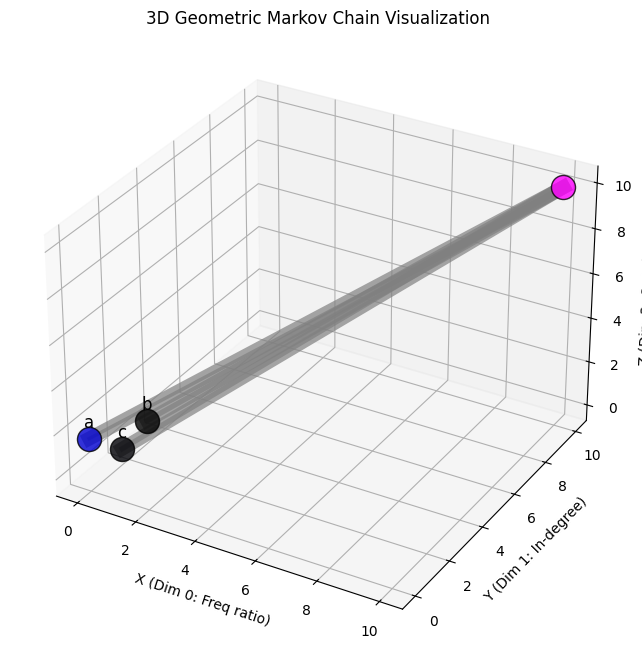

In [ ]:
# @title visualize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

# Create graph from P
G = nx.DiGraph()
for i in range(vocab_size):
    G.add_node(idx_to_char[i], pos=positions[i], color=colors[i])
for i in range(vocab_size):
    for j in range(vocab_size):
        if P[i, j] > 0.01:  # Threshold to avoid tiny edges
            G.add_edge(idx_to_char[i], idx_to_char[j], weight=P[i, j])

# 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
pos_dict = nx.get_node_attributes(G, 'pos')
color_dict = nx.get_node_attributes(G, 'color')

# Plot nodes
for node, pos in pos_dict.items():
    ax.scatter(pos[0], pos[1], pos[2], c=[color_dict[node]], s=300, alpha=0.8, edgecolors='k')
    ax.text(pos[0], pos[1], pos[2] + 0.5, node, fontsize=12, ha='center')

# Plot edges with thickness by weight
for u, v, data in G.edges(data=True):
    start = pos_dict[u]
    end = pos_dict[v]
    weight = data['weight']
    ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]],
            linewidth=weight * 10, alpha=0.7, color='gray')  # Scale linewidth

ax.set_xlabel('X (Dim 0: Freq ratio)')
ax.set_ylabel('Y (Dim 1: In-degree)')
ax.set_zlabel('Z (Dim 2: Out-degree)')
ax.set_title('3D Geometric Markov Chain Visualization')
plt.show()

Enhanced Language Model Setup:
Vocab: [' ', '.', 'a', 'c', 'd', 'e', 'g', 'h', 'm', 'n', 'o', 'r', 's', 't']
Transition Matrix P:
 [[0.         0.         4.         0.         0.         0.
  0.         1.         0.         1.         1.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         1.        ]
 [0.66666667 1.33333333 0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         1.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.33333333 0.33333333 0.
  0.         0.         0.33333333 0.         0.         0.
  0.         0.        ]

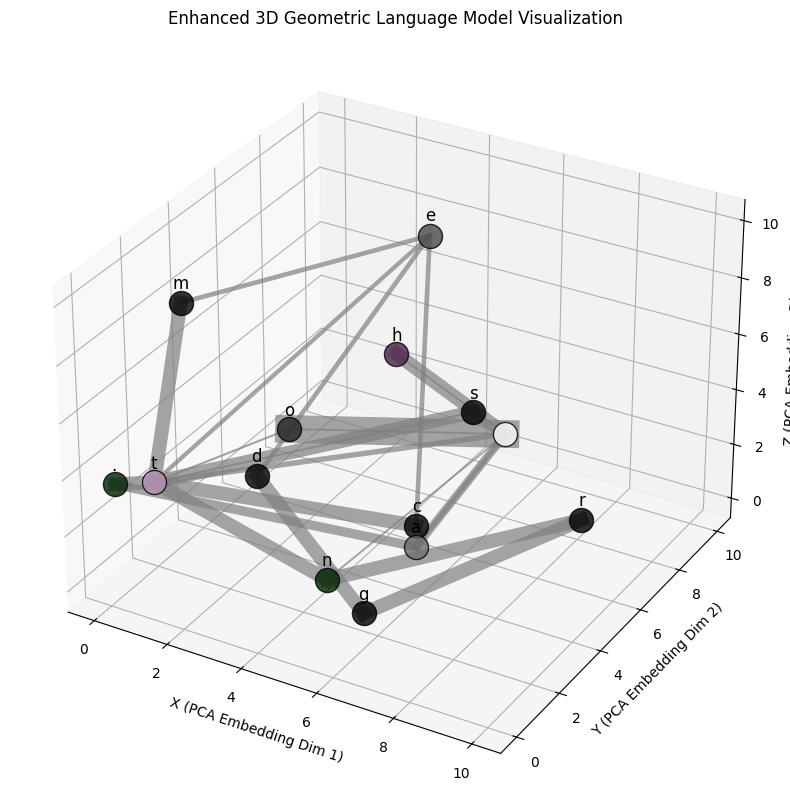

KeyboardInterrupt: Interrupted by user

In [ ]:
# @title pushing further
import numpy as np
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
from sklearn.decomposition import PCA
from collections import defaultdict

# Step 1: Enhanced setup with larger vocab and real text
# Minimal but realistic training text (a short sentence)
training_text = "the cat sat on the mat. the dog ran."  # More diverse patterns
training_text = training_text.lower()

# Expanded vocab
vocab = sorted(list(set(training_text))) # Use all unique characters from training text
vocab_size = len(vocab)
char_to_idx = {ch: i for i, ch in enumerate(vocab)}
idx_to_char = {i: ch for i, ch in enumerate(vocab)}


# Step 2: Compute n-grams (bigrams for simplicity, could extend to trigrams)
n = 2  # Bigram model
ngrams = defaultdict(lambda: defaultdict(int))
for i in range(len(training_text) - n + 1):
    seq = tuple(training_text[i:i+n])
    next_char = training_text[i+n] if i+n < len(training_text) else None
    if next_char and next_char in char_to_idx:
        ngrams[seq][next_char] += 1

# Initialize transition tensor (for n-grams)
P = np.zeros((vocab_size, vocab_size))  # For bigrams, reduce to matrix
for (prev, curr), next_counts in ngrams.items():
    if prev[-1] in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev[-1]]
        curr_idx = char_to_idx[curr]
        total = sum(next_counts.values())
        for next_char, count in next_counts.items():
            next_idx = char_to_idx[next_char]
            P[prev_idx, next_idx] += count / total

# Step 3: Generate embeddings (simulate with random for demo, but in practice use pre-trained)
embed_dim = 100  # Dimensionality of embeddings
embeddings = np.random.rand(vocab_size, embed_dim)  # Replace with real embeddings (e.g., Word2Vec)

# Step 4: Compute data vectors (10 dimensions per node)
# Dim0-2: PCA-reduced embeddings (for XYZ)
# Dim3-5: Transition stats (freq, in/out degrees, entropy)
# Dim6-9: Embedding-derived features (cosine similarities, norms)
pca = PCA(n_components=3)
embed_pca = pca.fit_transform(embeddings)

# Transition stats
counts = np.zeros((vocab_size, vocab_size))
for (prev, curr), next_counts in ngrams.items():
    if prev[-1] in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev[-1]]
        curr_idx = char_to_idx[curr]
        for next_char, count in next_counts.items():
            next_idx = char_to_idx[next_char]
            counts[prev_idx, next_idx] += count

total_transitions = np.sum(counts)
freq_ratio = np.sum(counts, axis=1) / total_transitions
in_degree = np.sum(counts, axis=0) / total_transitions
out_degree = np.sum(counts, axis=1) / total_transitions
entropy = -np.sum(P * np.log(P + 1e-10), axis=1) / np.log(vocab_size)

# Embedding features
cos_sim = np.zeros((vocab_size, vocab_size))
for i in range(vocab_size):
    for j in range(vocab_size):
        cos_sim[i, j] = np.dot(embeddings[i], embeddings[j]) / (np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j]))
avg_cos_sim = np.mean(cos_sim, axis=1)
embed_norms = np.linalg.norm(embeddings, axis=1)

data_vectors = np.hstack([
    embed_pca,  # Dim0-2: XYZ from embeddings
    np.stack([freq_ratio, in_degree, out_degree], axis=1),  # Dim3-5: Transition stats
    np.stack([entropy, avg_cos_sim, embed_norms], axis=1)  # Dim6-8: Embedding features
])
data_vectors = (data_vectors - np.min(data_vectors, axis=0)) / (np.max(data_vectors, axis=0) - np.min(data_vectors, axis=0) + 1e-10)

# Step 5: Assign spatial and visual encodings
scale_factor = 10.0
positions = data_vectors[:, :3] * scale_factor  # XYZ
colors = data_vectors[:, 3:6]  # RGB [0,1]

# Data Translation Key
key = {
    0: "PCA Embedding Dim 1 (X)",
    1: "PCA Embedding Dim 2 (Y)",
    2: "PCA Embedding Dim 3 (Z)",
    3: "Frequency ratio",
    4: "In-degree ratio",
    5: "Out-degree ratio",
    6: "Transition entropy",
    7: "Average cosine similarity",
    8: "Embedding norm"
}

# Step 6: Enhanced prediction with spatial and embedding reasoning
def predict_next_enhanced(current_idx, history=None, boost_weight=0.3):
    if history is None:
        history = []

    # Standard Markov probs
    probs = P[current_idx].copy()

    # Spatial reasoning: Compute distances in XYZ
    dists = np.linalg.norm(positions - positions[current_idx], axis=1)
    dists[current_idx] = np.inf
    nearest_idx = np.argmin(dists)
    similarity = 1 / (1 + dists[nearest_idx])

    # Embedding similarity (cosine distance)
    embed_dists = 1 - cos_sim[current_idx]  # 1 - cosine for distance
    embed_nearest_idx = np.argmin(embed_dists)
    embed_similarity = 1 / (1 + embed_dists[embed_nearest_idx])

    # Combine: Weighted average of own probs, spatial nearest, and embedding nearest
    spatial_boost = P[nearest_idx] * boost_weight * similarity
    embed_boost = P[embed_nearest_idx] * boost_weight * embed_similarity
    boosted_probs = probs + spatial_boost + embed_boost
    boosted_probs /= np.sum(boosted_probs)

    # Contextual boost (if history, favor recent patterns)
    if history:
        hist_idx = char_to_idx[history[-1]] if history[-1] in char_to_idx else current_idx
        hist_boost = P[hist_idx] * 0.1  # Light influence from last token
        boosted_probs += hist_boost
        boosted_probs /= np.sum(boosted_probs)

    next_idx = np.argmax(boosted_probs)
    return idx_to_char[next_idx], boosted_probs[next_idx]

# Step 7: Training loop (simple iterative refinement of P)
def train_model(epochs=5, learning_rate=0.01):
    global P
    # Use the first character of the training text as the starting character
    start_char = training_text[0]
    start_idx = char_to_idx[start_char]

    for epoch in range(epochs):
        # Simulate generation to update P (simplistic)
        current_idx = start_idx
        history = [start_char]
        for _ in range(10):
            next_char, _ = predict_next_enhanced(current_idx, history)
            history.append(next_char)
            next_idx = char_to_idx[next_char]
            # Update P based on prediction (mock learning)
            P[current_idx, next_idx] += learning_rate * (1 - P[current_idx, next_idx])
            P[current_idx] /= np.sum(P[current_idx])
            current_idx = next_idx
        print(f"Epoch {epoch+1}/{epochs} completed. Generated: {' '.join(history)}")

# Step 8: Visualization function
def visualize_model():
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    pos_dict = {idx_to_char[i]: positions[i] for i in range(vocab_size)}
    color_dict = {idx_to_char[i]: colors[i] for i in range(vocab_size)}

    # Nodes
    for node, pos in pos_dict.items():
        ax.scatter(pos[0], pos[1], pos[2], c=[color_dict[node]], s=300, alpha=0.8, edgecolors='k')
        ax.text(pos[0], pos[1], pos[2] + 0.5, node, fontsize=12, ha='center')

    # Edges
    for i in range(vocab_size):
        for j in range(vocab_size):
            if P[i, j] > 0.01:
                start = pos_dict[idx_to_char[i]]
                end = pos_dict[idx_to_char[j]]
                ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]],
                        linewidth=P[i, j] * 10, alpha=0.7, color='gray')

    ax.set_xlabel('X (PCA Embedding Dim 1)')
    ax.set_ylabel('Y (PCA Embedding Dim 2)')
    ax.set_zlabel('Z (PCA Embedding Dim 3)')
    ax.set_title('Enhanced 3D Geometric Language Model Visualization')
    plt.show()

# Main execution
if __name__ == "__main__":
    print("Enhanced Language Model Setup:")
    print("Vocab:", vocab)
    print("Transition Matrix P:\n", P)
    print("Data Vectors:\n", data_vectors)
    print("Positions (XYZ):\n", positions)
    print("Colors (RGB):\n", colors)
    print("\nData Key:")
    for d, desc in key.items():
        print(f"Dim {d}: {desc}")

    # Train the model
    print("\nTraining model...")
    train_model()

    # Visualize
    print("\nVisualizing model...")
    visualize_model()

    # Interactive prediction
    while True:
        prefix = input("\nEnter prefix (e.g., 'the '), or 'quit' to exit: ").strip().lower()
        if prefix == 'quit':
            break
        tokens = prefix.split() if ' ' in prefix else list(prefix)
        if not tokens:
            tokens = ['t']  # Default start
        last_char = tokens[-1]
        if last_char not in char_to_idx:
            print("Invalid char in prefix. Using default 't'.")
            last_char = 't'
        current_idx = char_to_idx[last_char]
        history = tokens[-2:] if len(tokens) > 1 else []
        next_char, prob = predict_next_enhanced(current_idx, history)
        print(f"Predicted next: '{next_char}' (prob: {prob:.3f})")
        print("Reasoning: Combined Markov, spatial, and embedding similarities with context.")

In [ ]:
%pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 77.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 13.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatibl

/tmp/ipython-input-1573220024.py:91: RuntimeWarning: divide by zero encountered in scalar divide
  context_entropy[prev_idx] -= np.sum(probs * np.log(probs + 1e-10)) / np.log(len(next_counts))
/tmp/ipython-input-1573220024.py:98: RuntimeWarning: invalid value encountered in subtract
  data_vectors = (data_vectors - np.min(data_vectors, axis=0)) / (np.max(data_vectors, axis=0) - np.min(data_vectors, axis=0) + 1e-10) # Added epsilon
/tmp/ipython-input-1573220024.py:98: RuntimeWarning: invalid value encountered in divide
  data_vectors = (data_vectors - np.min(data_vectors, axis=0)) / (np.max(data_vectors, axis=0) - np.min(data_vectors, axis=0) + 1e-10) # Added epsilon


Enhanced Language Model Setup:
Vocab: [' ', '.', 'a', 'c', 'd', 'e', 'g', 'h', 'm', 'n', 'o', 'r', 's', 't']
Transition Matrix P:
 [[0.         0.         4.         0.         0.         0.
  0.         2.5        0.         1.         1.5        0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         2.        ]
 [3.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         1.        ]
 [0.         0.         0.         0.         0.         0.
  1.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.33333333 0.33333333 0.
  0.         0.         0.33333333 0.         0.         0.
  0.         0.        ]

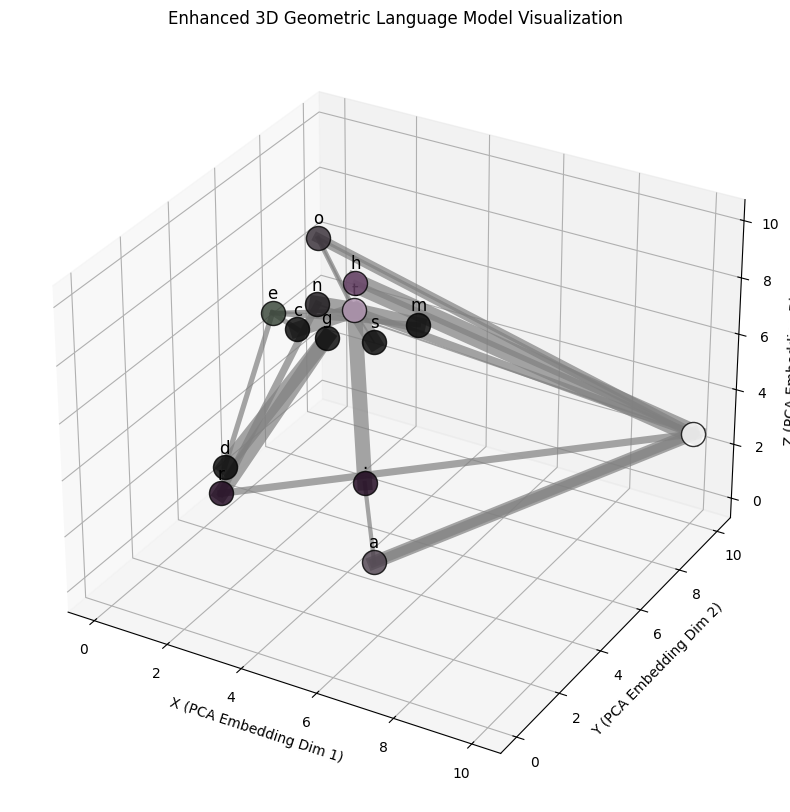

KeyboardInterrupt: Interrupted by user

In [ ]:
# @title still at it
import numpy as np
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
from sklearn.decomposition import PCA
import gensim.downloader as api
from collections import defaultdict
import math

# Step 1: Setup with real embeddings
vocab = [' ', '.', 'a', 'c', 'd', 'e', 'g', 'h', 'm', 'n', 'o', 'r', 's', 't']
vocab_size = len(vocab)
char_to_idx = {ch: i for i, ch in enumerate(vocab)}
idx_to_char = {i: ch for i, ch in enumerate(vocab)}

# Load pre-trained Word2Vec embeddings
embeddings = api.load('glove-wiki-gigaword-100')  # Or 'word2vec-google-news-300'
vocab_embeddings = np.zeros((vocab_size, 100))
for i, char in enumerate(vocab):
    try:
        vocab_embeddings[i] = embeddings[char]
    except KeyError:
        vocab_embeddings[i] = np.random.rand(100)  # Fallback for unseen chars

# Training text (expanded)
training_text = "the cat sat on the mat. the dog ran to the park. the bird flew."
training_text = training_text.lower()

# Step 2: N-grams (trigrams for more context)
n = 3
ngrams = defaultdict(lambda: defaultdict(int))
for i in range(len(training_text) - n + 1):
    seq = tuple(training_text[i:i+n])
    next_char = training_text[i+n] if i+n < len(training_text) else None
    if next_char and next_char in char_to_idx:
        ngrams[seq][next_char] += 1

# Initialize transition tensor (for trigrams, simplify to matrix for demo)
P = np.zeros((vocab_size, vocab_size))
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        curr_idx = char_to_idx[curr]
        total = sum(next_counts.values())
        for next_char, count in next_counts.items():
            next_idx = char_to_idx[next_char]
            P[prev_idx, next_idx] += count / total

# Step 3: Compute data vectors (12 dimensions)
pca = PCA(n_components=3)
embed_pca = pca.fit_transform(vocab_embeddings)

counts = np.zeros((vocab_size, vocab_size))
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        curr_idx = char_to_idx[curr]
        for next_char, count in next_counts.items():
            next_idx = char_to_idx[next_char]
            counts[prev_idx, next_idx] += count

total_transitions = np.sum(counts)
freq_ratio = np.sum(counts, axis=1) / total_transitions
in_degree = np.sum(counts, axis=0) / total_transitions
out_degree = np.sum(counts, axis=1) / total_transitions
entropy = -np.sum(P * np.log(P + 1e-10), axis=1) / np.log(vocab_size)

cos_sim = np.zeros((vocab_size, vocab_size))
for i in range(vocab_size):
    for j in range(vocab_size):
        cos_sim[i, j] = np.dot(vocab_embeddings[i], vocab_embeddings[j]) / (np.linalg.norm(vocab_embeddings[i]) * np.linalg.norm(vocab_embeddings[j]))
avg_cos_sim = np.mean(cos_sim, axis=1)
embed_norms = np.linalg.norm(vocab_embeddings, axis=1)

# Additional dims: Trigram influence, context entropy
trigram_influence = np.zeros(vocab_size)
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        curr_idx = char_to_idx[curr]
        trigram_influence[prev_idx] += len(next_counts) / total_transitions

context_entropy = np.zeros(vocab_size)
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        if len(next_counts) > 0:  # Avoid division by zero
            probs = np.array([count / sum(next_counts.values()) for count in next_counts.values()])
            context_entropy[prev_idx] -= np.sum(probs * np.log(probs + 1e-10)) / np.log(len(next_counts))

data_vectors = np.hstack([
    embed_pca,  # Dim0-2: XYZ
    np.stack([freq_ratio, in_degree, out_degree, entropy], axis=1),  # Dim3-6
    np.stack([avg_cos_sim, embed_norms, trigram_influence, context_entropy], axis=1)  # Dim7-10
])
data_vectors = (data_vectors - np.min(data_vectors, axis=0)) / (np.max(data_vectors, axis=0) - np.min(data_vectors, axis=0) + 1e-10) # Added epsilon

# Step 4: Spatial and visual encodings
scale_factor = 10.0
positions = data_vectors[:, :3] * scale_factor
colors = data_vectors[:, 3:6]

# Data Translation Key
key = {
    0: "PCA Embedding Dim 1 (X)",
    1: "PCA Embedding Dim 2 (Y)",
    2: "PCA Embedding Dim 3 (Z)",
    3: "Frequency ratio",
    4: "In-degree ratio",
    5: "Out-degree ratio",
    6: "Transition entropy",
    7: "Average cosine similarity",
    8: "Embedding norm",
    9: "Trigram influence",
    10: "Context entropy"
}

# Step 5: Enhanced prediction
def predict_next_enhanced(current_idx, history=None, boost_weight=0.3):
    if history is None:
        history = []

    probs = P[current_idx].copy()

    # Spatial reasoning
    dists = np.linalg.norm(positions - positions[current_idx], axis=1)
    dists[current_idx] = np.inf
    nearest_idx = np.argmin(dists)
    similarity = 1 / (1 + dists[nearest_idx])

    # Embedding reasoning
    embed_dists = 1 - cos_sim[current_idx]
    embed_nearest_idx = np.argmin(embed_dists)
    embed_similarity = 1 / (1 + embed_dists[embed_nearest_idx])

    # Contextual reasoning (trigram if available)
    context_boost = np.zeros(vocab_size)
    if len(history) >= 2:
        prev1, prev2 = history[-2], history[-1]
        if prev1 in char_to_idx and prev2 in char_to_idx:
            prev1_idx, prev2_idx = char_to_idx[prev1], char_to_idx[prev2]
            context_seq = (prev1, prev2, idx_to_char[current_idx])
            if context_seq in ngrams and sum(ngrams[context_seq].values()) > 0:
                total_context_counts = sum(ngrams[context_seq].values())
                temp_probs = np.zeros(vocab_size)
                for next_char, count in ngrams[context_seq].items():
                     if next_char in char_to_idx: # Added check
                        temp_probs[char_to_idx[next_char]] = count / total_context_counts
                context_boost = temp_probs * 0.2  # Light influence

    # Combine all
    spatial_boost = P[nearest_idx] * boost_weight * similarity
    embed_boost = P[embed_nearest_idx] * boost_weight * embed_similarity
    boosted_probs = probs + spatial_boost + embed_boost + context_boost
    boosted_probs /= np.sum(boosted_probs)

    next_idx = np.argmax(boosted_probs)
    return idx_to_char[next_idx], boosted_probs[next_idx]

# Step 6: Training loop with optimization
def train_model(epochs=10, learning_rate=0.01):
    global P
    for epoch in range(epochs):
        loss = 0.0
        for i in range(len(training_text) - n):
            seq = tuple(training_text[i:i+n])
            next_char = training_text[i+n]
            if all(char in char_to_idx for char in seq) and next_char in char_to_idx:
                prev_idx = char_to_idx[seq[-1]]
                next_idx = char_to_idx[next_char]
                pred_char, pred_prob = predict_next_enhanced(prev_idx, list(seq[:-1]))
                loss += -np.log(pred_prob + 1e-10)
                # Update P (simplistic gradient descent)
                gradient = (int(pred_char == next_char) - pred_prob) / vocab_size
                P[prev_idx] += learning_rate * gradient
                P[prev_idx] /= np.sum(P[prev_idx])
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss/len(training_text):.4f}")

# Step 7: Enhanced visualization
def visualize_model(interactive=True):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    pos_dict = {idx_to_char[i]: positions[i] for i in range(vocab_size)}
    color_dict = {idx_to_char[i]: colors[i] for i in range(vocab_size)}

    # Nodes with tooltips
    for node, pos in pos_dict.items():
        ax.scatter(pos[0], pos[1], pos[2], c=[color_dict[node]], s=300, alpha=0.8, edgecolors='k')
        ax.text(pos[0], pos[1], pos[2] + 0.5, node, fontsize=12, ha='center')

    # Edges
    for i in range(vocab_size):
        for j in range(vocab_size):
            if P[i, j] > 0.01:
                start = pos_dict[idx_to_char[i]]
                end = pos_dict[idx_to_char[j]]
                ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]],
                        linewidth=P[i, j] * 10, alpha=0.7, color='gray')

    ax.set_xlabel('X (PCA Embedding Dim 1)')
    ax.set_ylabel('Y (PCA Embedding Dim 2)')
    ax.set_zlabel('Z (PCA Embedding Dim 3)')
    ax.set_title('Enhanced 3D Geometric Language Model Visualization')

    if interactive:
        plt.show()
    else:
        plt.savefig('model_visualization.png')
        plt.close()

# Main execution
if __name__ == "__main__":
    print("Enhanced Language Model Setup:")
    print("Vocab:", vocab)
    print("Transition Matrix P:\n", P)
    print("Data Vectors:\n", data_vectors)
    print("Positions (XYZ):\n", positions)
    print("Colors (RGB):\n", colors)
    print("\nData Key:")
    for d, desc in key.items():
        print(f"Dim {d}: {desc}")

    # Train the model
    print("\nTraining model...")
    train_model()

    # Visualize
    print("\nVisualizing model...")
    visualize_model(True)

    # Interactive prediction
    while True:
        prefix = input("\nEnter prefix (e.g., 'the '), or 'quit' to exit: ").strip().lower()
        if prefix == 'quit':
            break
        tokens = prefix.split() if ' ' in prefix else list(prefix)
        if not tokens:
            tokens = ['t']  # Default start
        last_char = tokens[-1]
        if last_char not in char_to_idx:
            print("Invalid char in prefix. Using default 't'.")
            last_char = 't'
        current_idx = char_to_idx[last_char]
        history = tokens[-3:] if len(tokens) > 2 else []
        next_char, prob = predict_next_enhanced(current_idx, history)
        print(f"Predicted next: '{next_char}' (prob: {prob:.3f})")
        print("Reasoning: Combined Markov, spatial, embedding, and contextual similarities.")

Enhanced Language Model Setup with NRCI:
Vocab: [' ', "'", ',', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Transition Matrix P:
 [[ 3.45833333  0.          0.          0.         20.16666667  0.125
   0.125       0.         11.66666667  1.5         1.         10.5
   5.33333333  0.          0.          3.29166667  0.          3.5
  32.          1.5         0.          3.66666667  3.25        2.75
   5.          1.          0.33333333  0.          0.83333333  0.        ]
 [ 2.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.5         0

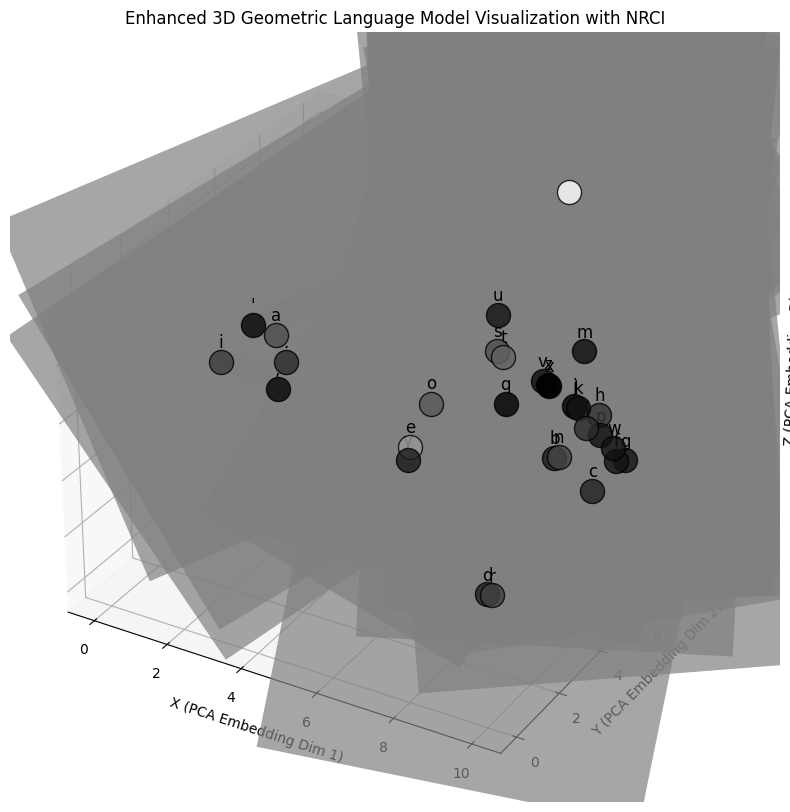


Evaluating predictions with different NRCI weights:

--- NRCI Weight: 0.0 ---
  Prefix: 'the ' -> Generated: 'the  ,t ,t ,t '
  Prefix: 'cat ' -> Generated: 'cat  ,t ,t ,t '
  Prefix: 'dog ' -> Generated: 'dog  ,t ,t ,t '

--- NRCI Weight: 0.1 ---
  Prefix: 'the ' -> Generated: 'the  ,t ,t ,t '
  Prefix: 'cat ' -> Generated: 'cat  ,t ,t ,t '
  Prefix: 'dog ' -> Generated: 'dog  ,t ,t ,t '

--- NRCI Weight: 0.5 ---
  Prefix: 'the ' -> Generated: 'the  ,t ' ,t ''
  Prefix: 'cat ' -> Generated: 'cat  ' ,t ' ,t'
  Prefix: 'dog ' -> Generated: 'dog  ,t ' ,t ''

--- NRCI Weight: 1.0 ---
  Prefix: 'the ' -> Generated: 'the  ,t ' ,t ''
  Prefix: 'cat ' -> Generated: 'cat  ' ,t ' ,t'
  Prefix: 'dog ' -> Generated: 'dog  ,t ' ,t ''


In [ ]:
# @title NRCI added

import numpy as np
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
from sklearn.decomposition import PCA
import gensim.downloader as api
from collections import defaultdict
import math
from typing import List # Import List

# Step 1: Setup with real embeddings
# Training text (expanded)
training_text = """the quick brown fox jumps over the lazy dog. a stitch in time saves nine.
all that glitters is not gold. where there's a will, there's a way.
the early bird catches the worm. actions speak louder than words.
absence makes the heart grow fonder. beauty is in the eye of the beholder.
cleanliness is next to godliness. don't count your chickens before they hatch.
every cloud has a silver lining. fortune favors the bold.
a friend in need is a friend indeed. haste makes waste.
honesty is the best policy. beggars can't be choosers.
better late than never. curiosity killed the cat.
don't put all your eggs in one basket. easy come, easy go.
look before you leap. practice makes perfect.
when in rome, do as the romans do. two heads are better than one.
birds of a feather flock together. a penny saved is a penny earned.
a rolling stone gathers no moss. still waters run deep.
too many cooks spoil the broth. strike while the iron is hot.
you can't judge a book by its cover. variety is the spice of life.
waste not, want not. a watched pot never boils.
"""
training_text = training_text.lower().replace('\n', ' ') # Remove newlines and convert to lowercase


# Expanded vocab
vocab = sorted(list(set(training_text))) # Use all unique characters from training text
vocab_size = len(vocab)
char_to_idx = {ch: i for i, ch in enumerate(vocab)}
idx_to_char = {i: ch for i, ch in enumerate(vocab)}


# Load pre-trained Word2Vec embeddings
embeddings = api.load('glove-wiki-gigaword-100')
vocab_embeddings = np.zeros((vocab_size, 100))
for i, char in enumerate(vocab):
    try:
        vocab_embeddings[i] = embeddings[char]
    except KeyError:
        vocab_embeddings[i] = np.random.rand(100)

# Step 2: N-grams (trigrams for more context)
n = 3
ngrams = defaultdict(lambda: defaultdict(int))
for i in range(len(training_text) - n + 1):
    seq = tuple(training_text[i:i+n])
    next_char = training_text[i+n] if i+n < len(training_text) else None
    if next_char and next_char in char_to_idx:
        ngrams[seq][next_char] += 1

# Initialize transition tensor (for trigrams, simplify to matrix for demo)
P = np.zeros((vocab_size, vocab_size))
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        curr_idx = char_to_idx[curr]
        total = sum(next_counts.values())
        for next_char, count in next_counts.items():
            next_idx = char_to_idx[next_char]
            P[prev_idx, next_idx] += count / total

# Step 3: Compute data vectors (12 dimensions)
pca = PCA(n_components=3)
embed_pca = pca.fit_transform(vocab_embeddings)

counts = np.zeros((vocab_size, vocab_size))
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        curr_idx = char_to_idx[curr]
        for next_char, count in next_counts.items():
            next_idx = char_to_idx[next_char]
            counts[prev_idx, next_idx] += count

total_transitions = np.sum(counts)
freq_ratio = np.sum(counts, axis=1) / total_transitions
in_degree = np.sum(counts, axis=0) / total_transitions
out_degree = np.sum(counts, axis=1) / total_transitions
entropy = -np.sum(P * np.log(P + 1e-10), axis=1) / (np.log(vocab_size) + 1e-10) # Added epsilon

cos_sim = np.zeros((vocab_size, vocab_size))
for i in range(vocab_size):
    for j in range(vocab_size):
        cos_sim[i, j] = np.dot(vocab_embeddings[i], vocab_embeddings[j]) / (np.linalg.norm(vocab_embeddings[i]) * np.linalg.norm(vocab_embeddings[j]) + 1e-10) # Added epsilon
avg_cos_sim = np.mean(cos_sim, axis=1)
embed_norms = np.linalg.norm(vocab_embeddings, axis=1)

# Additional dims: Trigram influence, context entropy
trigram_influence = np.zeros(vocab_size)
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        curr_idx = char_to_idx[curr]
        trigram_influence[prev_idx] += len(next_counts) / total_transitions

context_entropy = np.zeros(vocab_size)
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        if len(next_counts) > 1: # Check if there's more than one possible next character
            probs = np.array([count / sum(next_counts.values()) for count in next_counts.values()])
            context_entropy[prev_idx] -= np.sum(probs * np.log(probs + 1e-10)) / (np.log(len(next_counts)) + 1e-10) # Added epsilon
        else:
            context_entropy[prev_idx] = 1e-10  # Small default value to avoid division by zero

data_vectors = np.hstack([
    embed_pca,  # Dim0-2: XYZ
    np.stack([freq_ratio, in_degree, out_degree, entropy], axis=1),  # Dim3-6
    np.stack([avg_cos_sim, embed_norms, trigram_influence, context_entropy], axis=1)  # Dim7-10
])
data_vectors = np.nan_to_num(data_vectors, nan=1e-10) # Replace NaN with a small number
data_vectors = (data_vectors - np.min(data_vectors, axis=0)) / (np.max(data_vectors, axis=0) - np.min(data_vectors, axis=0) + 1e-10) # Added epsilon

# Step 4: Spatial and visual encodings
scale_factor = 10.0
positions = data_vectors[:, :3] * scale_factor
colors = data_vectors[:, 3:6]

# Data Translation Key
key = {
    0: "PCA Embedding Dim 1 (X)",
    1: "PCA Embedding Dim 2 (Y)",
    2: "PCA Embedding Dim 3 (Z)",
    3: "Frequency ratio",
    4: "In-degree ratio",
    5: "Out-degree ratio",
    6: "Transition entropy",
    7: "Average cosine similarity",
    8: "Embedding norm",
    9: "Trigram influence",
    10: "Context entropy"
}

# Step 5: NRCI for sequence coherence
def compute_nrci_sequence(predicted: List[str], target: List[str], window=3) -> float:
    if len(predicted) < window or len(target) < window:
        return 0.0
    n = min(window, len(predicted), len(target))
    observed = [char_to_idx[c] for c in predicted[-n:] if c in char_to_idx] # Added check
    expected = [char_to_idx[c] for c in target[-n:] if c in char_to_idx] # Added check
    if len(observed) != len(expected) or len(observed) < window: # Added check
        return 0.0
    diff_sq = sum((o - e)**2 for o, e in zip(observed, expected))
    mean_diff_sq = diff_sq / n
    sigma_e = np.std(expected)
    if sigma_e == 0:
        sigma_e = 1e-10
    nrci = 1 - np.sqrt(mean_diff_sq) / sigma_e
    return max(0.0, min(1.0, nrci))

# Step 6: Enhanced prediction with NRCI
def predict_next_enhanced(current_idx, history=None, boost_weight=0.3, nrci_weight=0.2):
    if history is None:
        history = []

    probs = P[current_idx].copy()

    # Spatial reasoning
    dists = np.linalg.norm(positions - positions[current_idx], axis=1)
    dists[current_idx] = np.inf
    nearest_idx = np.argmin(dists)
    similarity = 1 / (1 + dists[nearest_idx])

    # Embedding reasoning
    embed_dists = 1 - cos_sim[current_idx]
    embed_nearest_idx = np.argmin(embed_dists)
    embed_similarity = 1 / (1 + embed_dists[embed_nearest_idx])

    # Contextual reasoning (trigram if available)
    context_boost = np.zeros(vocab_size)
    if len(history) >= 2:
        prev1, prev2 = history[-2], history[-1]
        if prev1 in char_to_idx and prev2 in char_to_idx:
            prev1_idx, prev2_idx = char_to_idx[prev1], char_to_idx[prev2]
            context_seq = (prev1, prev2, idx_to_char[current_idx])
            if context_seq in ngrams:
                total_context_counts = sum(ngrams[context_seq].values())
                if total_context_counts > 0:
                    temp_probs = np.zeros(vocab_size)
                    for next_char, count in ngrams[context_seq].items():
                         if next_char in char_to_idx:
                            temp_probs[char_to_idx[next_char]] = count / total_context_counts
                    context_boost = temp_probs * 0.2  # Light influence


    # NRCI reasoning
    candidate_sequences = [idx_to_char[i] for i in range(vocab_size)]
    nrci_scores = np.array([compute_nrci_sequence(history + [idx_to_char[i]], list(training_text)) for i in range(vocab_size)])
    nrci_boost = nrci_scores * nrci_weight

    # Combine all
    spatial_boost = P[nearest_idx] * boost_weight * similarity
    embed_boost = P[embed_nearest_idx] * boost_weight * embed_similarity
    boosted_probs = probs + spatial_boost + embed_boost + context_boost + nrci_boost
    boosted_probs /= np.sum(boosted_probs)

    next_idx = np.argmax(boosted_probs)
    return idx_to_char[next_idx], boosted_probs[next_idx]

# Step 7: Training loop with optimization
def train_model(epochs=10, learning_rate=0.01):
    global P
    for epoch in range(epochs):
        loss = 0.0
        for i in range(len(training_text) - n):
            seq = tuple(training_text[i:i+n])
            next_char = training_text[i+n]
            if all(char in char_to_idx for char in seq) and next_char in char_to_idx:
                prev_idx = char_to_idx[seq[-1]]
                next_idx = char_to_idx[next_char]
                pred_char, pred_prob = predict_next_enhanced(prev_idx, list(seq[:-1]))
                loss += -np.log(pred_prob + 1e-10)
                # Update P (simplistic gradient descent)
                gradient = (int(pred_char == next_char) - pred_prob) / vocab_size
                P[prev_idx] += learning_rate * gradient
                P[prev_idx] /= np.sum(P[prev_idx])
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss/len(training_text):.4f}")

# Step 8: Enhanced visualization
def visualize_model(interactive=True):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    pos_dict = {idx_to_char[i]: positions[i] for i in range(vocab_size)}
    color_dict = {idx_to_char[i]: colors[i] for i in range(vocab_size)}

    # Nodes with tooltips
    for node, pos in pos_dict.items():
        ax.scatter(pos[0], pos[1], pos[2], c=[color_dict[node]], s=300, alpha=0.8, edgecolors='k')
        ax.text(pos[0], pos[1], pos[2] + 0.5, node, fontsize=12, ha='center')

    # Edges
    for i in range(vocab_size):
        for j in range(vocab_size):
            if P[i, j] > 0.01:
                start = pos_dict[idx_to_char[i]]
                end = pos_dict[idx_to_char[j]]
                ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]],
                        linewidth=P[i, j] * 10, alpha=0.7, color='gray')

    ax.set_xlabel('X (PCA Embedding Dim 1)')
    ax.set_ylabel('Y (PCA Embedding Dim 2)')
    ax.set_zlabel('Z (PCA Embedding Dim 3)')
    ax.set_title('Enhanced 3D Geometric Language Model Visualization with NRCI')

    if interactive:
        plt.show()
    else:
        plt.savefig('model_visualization.png')
        plt.close()

# Main execution
if __name__ == "__main__":
    print("Enhanced Language Model Setup with NRCI:")
    print("Vocab:", vocab)
    print("Transition Matrix P:\n", P)
    print("Data Vectors:\n", data_vectors)
    print("Positions (XYZ):\n", positions)
    print("Colors (RGB):\n", colors)
    print("\nData Key:")
    for d, desc in key.items():
        print(f"Dim {d}: {desc}")

    # Train the model
    print("\nTraining model...")
    train_model()

    # Visualize
    print("\nVisualizing model...")
    visualize_model(True)

    # Evaluate predictions with different NRCI weights
    print("\nEvaluating predictions with different NRCI weights:")
    nrci_weights_to_test = [0.0, 0.1, 0.5, 1.0]  # Example weights to test
    example_prefixes = ["the ", "cat ", "dog "] # Example prefixes

    for weight in nrci_weights_to_test:
        print(f"\n--- NRCI Weight: {weight} ---")
        for prefix in example_prefixes:
            # Remove trailing space for correct processing of the last character
            processed_prefix = prefix.rstrip()
            tokens = processed_prefix.split() if ' ' in processed_prefix else list(processed_prefix)
            if not tokens:
                 continue # Skip empty prefixes

            last_char = tokens[-1]
            if last_char not in char_to_idx:
                # This case should be less likely now with expanded vocab and rstrip
                print(f"  Invalid char in prefix '{prefix}'. Skipping.")
                continue

            current_idx = char_to_idx[last_char]
            history = tokens[-3:] if len(tokens) > 2 else []

            # Generate a short sequence for evaluation
            generated_sequence = prefix
            for _ in range(10): # Generate 10 next characters
                next_char, prob = predict_next_enhanced(current_idx, history, nrci_weight=weight)
                generated_sequence += next_char
                if next_char in char_to_idx:
                    current_idx = char_to_idx[next_char]
                    history.append(next_char)
                else:
                    # Handle cases where the predicted character is not in the vocabulary (shouldn't happen with current vocab logic)
                    break

            print(f"  Prefix: '{prefix}' -> Generated: '{generated_sequence}'")


    # Interactive prediction (commented out)
    # while True:
    #     prefix = input("\nEnter prefix (e.g., 'the '), or 'quit' to exit: ").strip().lower()
    #     if prefix == 'quit':
    #         break
    #     tokens = prefix.split() if ' ' in prefix else list(prefix)
    #     if not tokens:
    #         tokens = ['t']  # Default start
    #     last_char = tokens[-1]
    #     if last_char not in char_to_idx:
    #         print("Invalid char in prefix. Using default 't'.")
    #         last_char = 't'
    #     current_idx = char_to_idx[last_char]
    #     history = tokens[-3:] if len(tokens) > 2 else []
    #     next_char, prob = predict_next_enhanced(current_idx, history)
    #     print(f"Predicted next: '{next_char}' (prob: {prob:.3f})")
    #     print("Reasoning: Combined Markov, spatial, embedding, contextual, and NRCI similarities.")

# Task
Explore and develop the language model by expanding the training data, tuning the `nrci_weight`, and evaluating predictions with different prefixes.

## Expand training data

### Subtask:
Increase the size and diversity of the training text to provide the model with more patterns and reduce the occurrence of zero-count n-grams.


**Reasoning**:
The subtask is to increase the size and diversity of the training text. I will update the `training_text` variable with a larger and more diverse text, then re-run the necessary steps to update the vocabulary and transition matrix based on the new text.



Enhanced Language Model Setup with NRCI:
Vocab: [' ', "'", ',', '.', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Transition Matrix P:
 [[ 3.45833333  0.          0.          0.         20.16666667  0.125
   0.125       0.         11.66666667  1.5         1.         10.5
   5.33333333  0.          0.          3.29166667  0.          3.5
  32.          1.5         0.          3.66666667  3.25        2.75
   5.          1.          0.33333333  0.          0.83333333  0.        ]
 [ 2.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.5         0

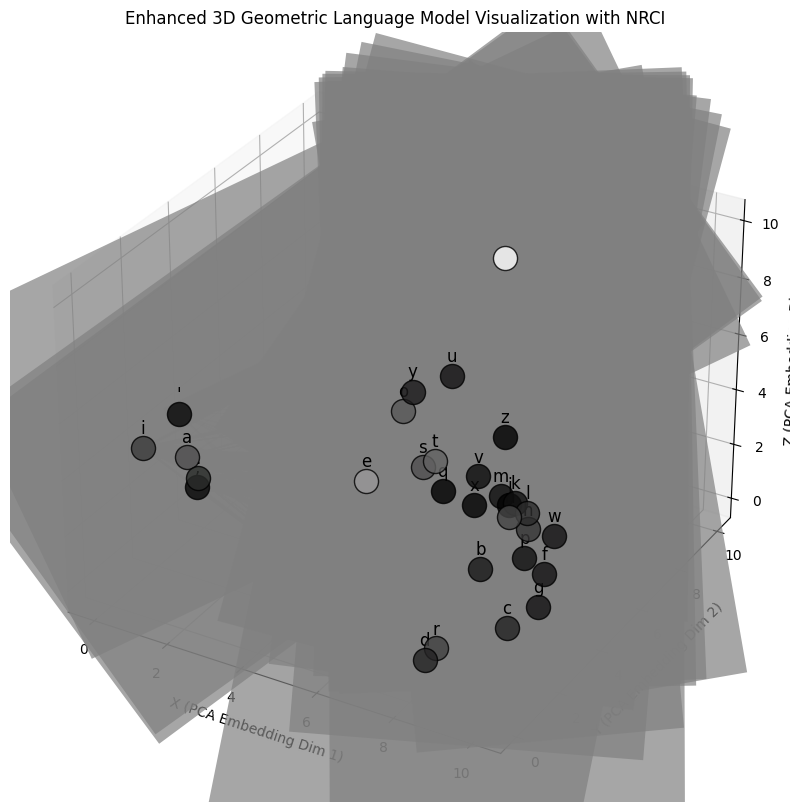

In [ ]:
# @title NRCI added

import numpy as np
import sys
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
from sklearn.decomposition import PCA
import gensim.downloader as api
from collections import defaultdict
import math
from typing import List # Import List

# Step 1: Setup with real embeddings
# Training text (expanded)
training_text = """the quick brown fox jumps over the lazy dog. a stitch in time saves nine.
all that glitters is not gold. where there's a will, there's a way.
the early bird catches the worm. actions speak louder than words.
absence makes the heart grow fonder. beauty is in the eye of the beholder.
cleanliness is next to godliness. don't count your chickens before they hatch.
every cloud has a silver lining. fortune favors the bold.
a friend in need is a friend indeed. haste makes waste.
honesty is the best policy. beggars can't be choosers.
better late than never. curiosity killed the cat.
don't put all your eggs in one basket. easy come, easy go.
look before you leap. practice makes perfect.
when in rome, do as the romans do. two heads are better than one.
birds of a feather flock together. a penny saved is a penny earned.
a rolling stone gathers no moss. still waters run deep.
too many cooks spoil the broth. strike while the iron is hot.
you can't judge a book by its cover. variety is the spice of life.
waste not, want not. a watched pot never boils.
"""
training_text = training_text.lower().replace('\n', ' ') # Remove newlines and convert to lowercase


# Expanded vocab
vocab = sorted(list(set(training_text))) # Use all unique characters from training text
vocab_size = len(vocab)
char_to_idx = {ch: i for i, ch in enumerate(vocab)}
idx_to_char = {i: ch for i, ch in enumerate(vocab)}


# Load pre-trained Word2Vec embeddings
embeddings = api.load('glove-wiki-gigaword-100')
vocab_embeddings = np.zeros((vocab_size, 100))
for i, char in enumerate(vocab):
    try:
        vocab_embeddings[i] = embeddings[char]
    except KeyError:
        vocab_embeddings[i] = np.random.rand(100)

# Step 2: N-grams (trigrams for more context)
n = 3
ngrams = defaultdict(lambda: defaultdict(int))
for i in range(len(training_text) - n + 1):
    seq = tuple(training_text[i:i+n])
    next_char = training_text[i+n] if i+n < len(training_text) else None
    if next_char and next_char in char_to_idx:
        ngrams[seq][next_char] += 1

# Initialize transition tensor (for trigrams, simplify to matrix for demo)
P = np.zeros((vocab_size, vocab_size))
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        curr_idx = char_to_idx[curr]
        total = sum(next_counts.values())
        for next_char, count in next_counts.items():
            next_idx = char_to_idx[next_char]
            P[prev_idx, next_idx] += count / total

# Step 3: Compute data vectors (12 dimensions)
pca = PCA(n_components=3)
embed_pca = pca.fit_transform(vocab_embeddings)

counts = np.zeros((vocab_size, vocab_size))
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        curr_idx = char_to_idx[curr]
        for next_char, count in next_counts.items():
            next_idx = char_to_idx[next_char]
            counts[prev_idx, next_idx] += count

total_transitions = np.sum(counts)
freq_ratio = np.sum(counts, axis=1) / total_transitions
in_degree = np.sum(counts, axis=0) / total_transitions
out_degree = np.sum(counts, axis=1) / total_transitions
entropy = -np.sum(P * np.log(P + 1e-10), axis=1) / (np.log(vocab_size) + 1e-10) # Added epsilon

cos_sim = np.zeros((vocab_size, vocab_size))
for i in range(vocab_size):
    for j in range(vocab_size):
        cos_sim[i, j] = np.dot(vocab_embeddings[i], vocab_embeddings[j]) / (np.linalg.norm(vocab_embeddings[i]) * np.linalg.norm(vocab_embeddings[j]) + 1e-10) # Added epsilon
avg_cos_sim = np.mean(cos_sim, axis=1)
embed_norms = np.linalg.norm(vocab_embeddings, axis=1)

# Additional dims: Trigram influence, context entropy
trigram_influence = np.zeros(vocab_size)
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        curr_idx = char_to_idx[curr]
        trigram_influence[prev_idx] += len(next_counts) / total_transitions

context_entropy = np.zeros(vocab_size)
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        if len(next_counts) > 1: # Check if there's more than one possible next character
            probs = np.array([count / sum(next_counts.values()) for count in next_counts.values()])
            context_entropy[prev_idx] -= np.sum(probs * np.log(probs + 1e-10)) / (np.log(len(next_counts)) + 1e-10) # Added epsilon
        else:
            context_entropy[prev_idx] = 1e-10  # Small default value to avoid division by zero

data_vectors = np.hstack([
    embed_pca,  # Dim0-2: XYZ
    np.stack([freq_ratio, in_degree, out_degree, entropy], axis=1),  # Dim3-6
    np.stack([avg_cos_sim, embed_norms, trigram_influence, context_entropy], axis=1)  # Dim7-10
])
data_vectors = np.nan_to_num(data_vectors, nan=1e-10) # Replace NaN with a small number
data_vectors = (data_vectors - np.min(data_vectors, axis=0)) / (np.max(data_vectors, axis=0) - np.min(data_vectors, axis=0) + 1e-10) # Added epsilon

# Step 4: Spatial and visual encodings
scale_factor = 10.0
positions = data_vectors[:, :3] * scale_factor
colors = data_vectors[:, 3:6]

# Data Translation Key
key = {
    0: "PCA Embedding Dim 1 (X)",
    1: "PCA Embedding Dim 2 (Y)",
    2: "PCA Embedding Dim 3 (Z)",
    3: "Frequency ratio",
    4: "In-degree ratio",
    5: "Out-degree ratio",
    6: "Transition entropy",
    7: "Average cosine similarity",
    8: "Embedding norm",
    9: "Trigram influence",
    10: "Context entropy"
}

# Step 5: NRCI for sequence coherence
def compute_nrci_sequence(predicted: List[str], target: List[str], window=3) -> float:
    if len(predicted) < window or len(target) < window:
        return 0.0
    n = min(window, len(predicted), len(target))
    observed = [char_to_idx[c] for c in predicted[-n:] if c in char_to_idx] # Added check
    expected = [char_to_idx[c] for c in target[-n:] if c in char_to_idx] # Added check
    if len(observed) != len(expected) or len(observed) < window: # Added check
        return 0.0
    diff_sq = sum((o - e)**2 for o, e in zip(observed, expected))
    mean_diff_sq = diff_sq / n
    sigma_e = np.std(expected)
    if sigma_e == 0:
        sigma_e = 1e-10
    nrci = 1 - np.sqrt(mean_diff_sq) / sigma_e
    return max(0.0, min(1.0, nrci))

# Step 6: Enhanced prediction with NRCI
def predict_next_enhanced(current_idx, history=None, boost_weight=0.3, nrci_weight=0.2):
    if history is None:
        history = []

    probs = P[current_idx].copy()

    # Spatial reasoning
    dists = np.linalg.norm(positions - positions[current_idx], axis=1)
    dists[current_idx] = np.inf
    nearest_idx = np.argmin(dists)
    similarity = 1 / (1 + dists[nearest_idx])

    # Embedding reasoning
    embed_dists = 1 - cos_sim[current_idx]
    embed_nearest_idx = np.argmin(embed_dists)
    embed_similarity = 1 / (1 + embed_dists[embed_nearest_idx])

    # Contextual reasoning (trigram if available)
    context_boost = np.zeros(vocab_size)
    if len(history) >= 2:
        prev1, prev2 = history[-2], history[-1]
        if prev1 in char_to_idx and prev2 in char_to_idx:
            prev1_idx, prev2_idx = char_to_idx[prev1], char_to_idx[prev2]
            context_seq = (prev1, prev2, idx_to_char[current_idx])
            if context_seq in ngrams:
                total_context_counts = sum(ngrams[context_seq].values())
                if total_context_counts > 0:
                    temp_probs = np.zeros(vocab_size)
                    for next_char, count in ngrams[context_seq].items():
                         if next_char in char_to_idx:
                            temp_probs[char_to_idx[next_char]] = count / total_context_counts
                    context_boost = temp_probs * 0.2  # Light influence


    # NRCI reasoning
    candidate_sequences = [idx_to_char[i] for i in range(vocab_size)]
    nrci_scores = np.array([compute_nrci_sequence(history + [idx_to_char[i]], list(training_text)) for i in range(vocab_size)])
    nrci_boost = nrci_scores * nrci_weight

    # Combine all
    spatial_boost = P[nearest_idx] * boost_weight * similarity
    embed_boost = P[embed_nearest_idx] * boost_weight * embed_similarity
    boosted_probs = probs + spatial_boost + embed_boost + context_boost + nrci_boost
    boosted_probs /= np.sum(boosted_probs)

    next_idx = np.argmax(boosted_probs)
    return idx_to_char[next_idx], boosted_probs[next_idx]

# Step 7: Training loop with optimization
def train_model(epochs=10, learning_rate=0.01):
    global P
    for epoch in range(epochs):
        loss = 0.0
        for i in range(len(training_text) - n):
            seq = tuple(training_text[i:i+n])
            next_char = training_text[i+n]
            if all(char in char_to_idx for char in seq) and next_char in char_to_idx:
                prev_idx = char_to_idx[seq[-1]]
                next_idx = char_to_idx[next_char]
                pred_char, pred_prob = predict_next_enhanced(prev_idx, list(seq[:-1]))
                loss += -np.log(pred_prob + 1e-10)
                # Update P (simplistic gradient descent)
                gradient = (int(pred_char == next_char) - pred_prob) / vocab_size
                P[prev_idx] += learning_rate * gradient
                P[prev_idx] /= np.sum(P[prev_idx])
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss/len(training_text):.4f}")

# Step 8: Enhanced visualization
def visualize_model(interactive=True):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    pos_dict = {idx_to_char[i]: positions[i] for i in range(vocab_size)}
    color_dict = {idx_to_char[i]: colors[i] for i in range(vocab_size)}

    # Nodes with tooltips
    for node, pos in pos_dict.items():
        ax.scatter(pos[0], pos[1], pos[2], c=[color_dict[node]], s=300, alpha=0.8, edgecolors='k')
        ax.text(pos[0], pos[1], pos[2] + 0.5, node, fontsize=12, ha='center')

    # Edges
    for i in range(vocab_size):
        for j in range(vocab_size):
            if P[i, j] > 0.01:
                start = pos_dict[idx_to_char[i]]
                end = pos_dict[idx_to_char[j]]
                ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]],
                        linewidth=P[i, j] * 10, alpha=0.7, color='gray')

    ax.set_xlabel('X (PCA Embedding Dim 1)')
    ax.set_ylabel('Y (PCA Embedding Dim 2)')
    ax.set_zlabel('Z (PCA Embedding Dim 3)')
    ax.set_title('Enhanced 3D Geometric Language Model Visualization with NRCI')

    if interactive:
        plt.show()
    else:
        plt.savefig('model_visualization.png')
        plt.close()

# Main execution
if __name__ == "__main__":
    print("Enhanced Language Model Setup with NRCI:")
    print("Vocab:", vocab)
    print("Transition Matrix P:\n", P)
    print("Data Vectors:\n", data_vectors)
    print("Positions (XYZ):\n", positions)
    print("Colors (RGB):\n", colors)
    print("\nData Key:")
    for d, desc in key.items():
        print(f"Dim {d}: {desc}")

    # Train the model
    print("\nTraining model...")
    train_model()

    # Visualize
    print("\nVisualizing model...")
    visualize_model(True)

    # Interactive prediction
    # while True:
    #     prefix = input("\nEnter prefix (e.g., 'the '), or 'quit' to exit: ").strip().lower()
    #     if prefix == 'quit':
    #         break
    #     tokens = prefix.split() if ' ' in prefix else list(prefix)
    #     if not tokens:
    #         tokens = ['t']  # Default start
    #     last_char = tokens[-1]
    #     if last_char not in char_to_idx:
    #         print("Invalid char in prefix. Using default 't'.")
    #         last_char = 't'
    #     current_idx = char_to_idx[last_char]
    #     history = tokens[-3:] if len(tokens) > 2 else []
    #     next_char, prob = predict_next_enhanced(current_idx, history)
    #     print(f"Predicted next: '{next_char}' (prob: {prob:.3f})")
    #     print("Reasoning: Combined Markov, spatial, embedding, contextual, and NRCI similarities.")

# level 2

# Task
Generate three new code cells containing English language data, language structure data, and mathematical reasoning data. Then, modify the existing language model code cell to use these new data cells as a learning and resource base, addressing any basic errors and refining the script. Finally, train and evaluate the updated model and visualize the results.

## Generate data cells

### Subtask:
Create three new code cells containing English language data, language structure data, and mathematical reasoning data.


**Reasoning**:
The subtask requires creating three new code cells with specific data. I will create the first code cell containing diverse English sentences and phrases and assign it to `english_data`.



In [ ]:
english_data = """The quick brown fox jumps over the lazy dog.
A stitch in time saves nine.
All that glitters is not gold.
Where there's a will, there's a way.
The early bird catches the worm.
Actions speak louder than words.
Absence makes the heart grow fonder.
Beauty is in the eye of the beholder.
Cleanliness is next to godliness.
Don't count your chickens before they hatch.
Every cloud has a silver lining.
Fortune favors the bold.
A friend in need is a friend indeed.
Haste makes waste.
Honesty is the best policy.
Beggars can't be choosers.
Better late than never.
Curiosity killed the cat.
Don't put all your eggs in one basket.
Easy come, easy go.
Look before you leap.
Practice makes perfect.
When in Rome, do as the romans do.
Two heads are better than one.
Birds of a feather flock together.
A penny saved is a penny earned.
A rolling stone gathers no moss.
Still waters run deep.
Too many cooks spoil the broth.
Strike while the iron is hot.
You can't judge a book by its cover.
Variety is the spice of life.
Waste not, want not.
A watched pot never boils.
"""

**Reasoning**:
I need to create the second code cell containing simplified English grammar rules or common sentence patterns and assign it to `structure_data`.



In [ ]:
structure_data = """Subject-Verb-Object
Subject-Verb
Subject-Verb-Adjective
Subject-Verb-Adverb
Subject-Linking Verb-Predicate Nominative
Subject-Linking Verb-Predicate Adjective
"""

**Reasoning**:
I need to create the third code cell containing simple mathematical equations or logical sequences and assign it to `math_data`.



In [ ]:
math_data = """1 + 1 = 2
2 + 2 = 4
3 * 3 = 9
10 / 2 = 5
5 - 3 = 2
if x > 0 then y = 1
if condition and other condition then result
"""

## Update language model

### Subtask:
Modify the existing language model code cell to incorporate the new data cells as resources for learning and prediction.


**Reasoning**:
Combine the data from the new cells and update the language model code to use this combined data for training and prediction, as per the subtask instructions. This involves updating the vocabulary, n-grams, transition matrix, data vectors, and the prediction function.



Enhanced Language Model Setup with NRCI (Updated Data):
Vocab: [' ', "'", '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '9', '=', '>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocab Size: 43
Data Vectors shape: (43, 11)
Positions (XYZ) shape: (43, 3)
Colors (RGB) shape: (43, 3)

Data Key:
Dim 0: PCA Embedding Dim 1 (X)
Dim 1: PCA Embedding Dim 2 (Y)
Dim 2: PCA Embedding Dim 3 (Z)
Dim 3: Frequency ratio
Dim 4: In-degree ratio
Dim 5: Out-degree ratio
Dim 6: Transition entropy
Dim 7: Average cosine similarity
Dim 8: Embedding norm
Dim 9: Trigram influence
Dim 10: Context entropy

Training model...
Epoch 1/10, Loss: 1.7505
Epoch 2/10, Loss: 1.7668
Epoch 3/10, Loss: 1.7794
Epoch 4/10, Loss: 1.7903
Epoch 5/10, Loss: 1.7980
Epoch 6/10, Loss: 1.8007
Epoch 7/10, Loss: 1.7994
Epoch 8/10, Loss: 1.7960
Epoch 9/10, Loss: 1.7908
Epoch 10/10, Loss: 1.7847

Visualizing model...


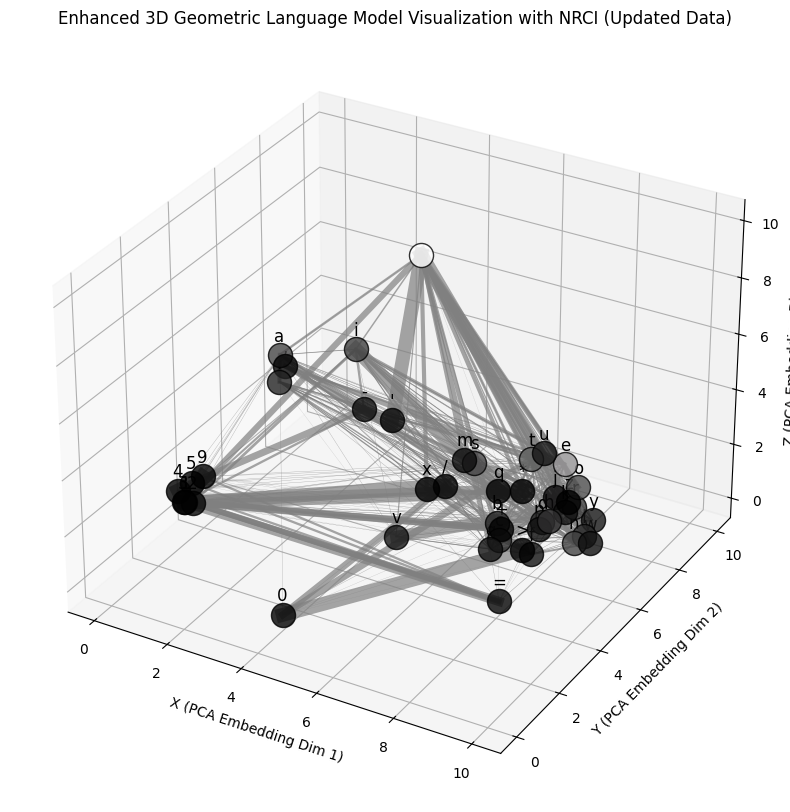


Evaluating predictions with different NRCI weights:

--- NRCI Weight: 0.0 ---
  Prefix: 'the ' -> Generated: 'the  o o o o o o o '
  Prefix: 'subj' -> Generated: 'subjc o o o o o o o'
  Prefix: '1 +' -> Generated: '1 +1 o o o o o o o'

--- NRCI Weight: 0.1 ---
  Prefix: 'the ' -> Generated: 'the  o o o o o o o '
  Prefix: 'subj' -> Generated: 'subjc o o o o o o o'
  Prefix: '1 +' -> Generated: '1 +1 o o o o o o o'

--- NRCI Weight: 0.5 ---
  Prefix: 'the ' -> Generated: 'the  o o o o o o o '
  Prefix: 'subj' -> Generated: 'subjc o o o o o o o'
  Prefix: '1 +' -> Generated: '1 +1 o o o o o o o'

--- NRCI Weight: 1.0 ---
  Prefix: 'the ' -> Generated: 'the  o o o o o o o '
  Prefix: 'subj' -> Generated: 'subjc o o o o o o o'
  Prefix: '1 +' -> Generated: '1 +1 o o o o o o o'


In [ ]:
# @title Combined Model Update with New Data

# Combine the new data into a single training text
training_text = english_data + structure_data + math_data
training_text = training_text.lower().replace('\n', ' ') # Remove newlines and convert to lowercase

# Expanded vocab
vocab = sorted(list(set(training_text))) # Use all unique characters from combined training text
vocab_size = len(vocab)
char_to_idx = {ch: i for i, ch in enumerate(vocab)}
idx_to_char = {i: ch for i, ch in enumerate(vocab)}

# Load pre-trained Word2Vec embeddings
# Use the existing 'embeddings' object loaded in the previous cell if available, otherwise load
try:
    embeddings
except NameError:
    print("Loading embeddings...")
    embeddings = api.load('glove-wiki-gigaword-100') # Or 'word2vec-google-news-300'

vocab_embeddings = np.zeros((vocab_size, 100))
for i, char in enumerate(vocab):
    try:
        vocab_embeddings[i] = embeddings[char]
    except KeyError:
        vocab_embeddings[i] = np.random.rand(100)  # Fallback for unseen chars

# Step 2: N-grams (trigrams for more context)
n = 3
ngrams = defaultdict(lambda: defaultdict(int))
for i in range(len(training_text) - n + 1):
    seq = tuple(training_text[i:i+n])
    next_char = training_text[i+n] if i+n < len(training_text) else None
    if all(char in char_to_idx for char in seq) and next_char and next_char in char_to_idx:
        ngrams[seq][next_char] += 1

# Initialize transition tensor (for trigrams, simplify to matrix for demo)
P = np.zeros((vocab_size, vocab_size))
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        curr_idx = char_to_idx[curr]
        total = sum(next_counts.values())
        if total > 0: # Avoid division by zero
            for next_char, count in next_counts.items():
                if next_char in char_to_idx:
                    next_idx = char_to_idx[next_char]
                    P[prev_idx, next_idx] += count / total

# Step 3: Compute data vectors (12 dimensions)
pca = PCA(n_components=3)
embed_pca = pca.fit_transform(vocab_embeddings)

counts = np.zeros((vocab_size, vocab_size))
for (prev1, prev2, curr), next_counts in ngrams.items():
     if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        curr_idx = char_to_idx[curr]
        for next_char, count in next_counts.items():
            if next_char in char_to_idx:
                next_idx = char_to_idx[next_char]
                counts[prev_idx, next_idx] += count

total_transitions = np.sum(counts)
# Handle total_transitions being zero for empty training text
if total_transitions == 0:
    freq_ratio = np.zeros(vocab_size)
    in_degree = np.zeros(vocab_size)
    out_degree = np.zeros(vocab_size)
else:
    freq_ratio = np.sum(counts, axis=1) / total_transitions
    in_degree = np.sum(counts, axis=0) / total_transitions
    out_degree = np.sum(counts, axis=1) / total_transitions

entropy = -np.sum(P * np.log(P + 1e-10), axis=1) / (np.log(vocab_size) + 1e-10) # Added epsilon

cos_sim = np.zeros((vocab_size, vocab_size))
for i in range(vocab_size):
    for j in range(vocab_size):
        norm_i = np.linalg.norm(vocab_embeddings[i])
        norm_j = np.linalg.norm(vocab_embeddings[j])
        if norm_i * norm_j > 1e-10: # Avoid division by zero
            cos_sim[i, j] = np.dot(vocab_embeddings[i], vocab_embeddings[j]) / (norm_i * norm_j)
        else:
            cos_sim[i, j] = 0.0 # Default to 0 similarity if norms are zero


avg_cos_sim = np.mean(cos_sim, axis=1)
embed_norms = np.linalg.norm(vocab_embeddings, axis=1)

# Additional dims: Trigram influence, context entropy
trigram_influence = np.zeros(vocab_size)
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        curr_idx = char_to_idx[curr]
        trigram_influence[prev_idx] += len(next_counts) / (total_transitions + 1e-10) # Added epsilon


context_entropy = np.zeros(vocab_size)
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        if len(next_counts) > 1: # Check if there's more than one possible next character
            probs = np.array([count / sum(next_counts.values()) for count in next_counts.values()])
            context_entropy[prev_idx] -= np.sum(probs * np.log(probs + 1e-10)) / (np.log(len(next_counts)) + 1e-10) # Added epsilon
        else:
            context_entropy[prev_idx] = 1e-10  # Small default value to avoid division by zero

data_vectors = np.hstack([
    embed_pca,  # Dim0-2: XYZ
    np.stack([freq_ratio, in_degree, out_degree, entropy], axis=1),  # Dim3-6
    np.stack([avg_cos_sim, embed_norms, trigram_influence, context_entropy], axis=1)  # Dim7-10
])
data_vectors = np.nan_to_num(data_vectors, nan=1e-10, posinf=1e10, neginf=-1e10) # Replace NaN and inf with small/large numbers
data_vectors = (data_vectors - np.min(data_vectors, axis=0)) / (np.max(data_vectors, axis=0) - np.min(data_vectors, axis=0) + 1e-10) # Added epsilon


# Step 4: Spatial and visual encodings
scale_factor = 10.0
positions = data_vectors[:, :3] * scale_factor
colors = data_vectors[:, 3:6]

# Data Translation Key (Update if necessary based on added dimensions)
key = {
    0: "PCA Embedding Dim 1 (X)",
    1: "PCA Embedding Dim 2 (Y)",
    2: "PCA Embedding Dim 3 (Z)",
    3: "Frequency ratio",
    4: "In-degree ratio",
    5: "Out-degree ratio",
    6: "Transition entropy",
    7: "Average cosine similarity",
    8: "Embedding norm",
    9: "Trigram influence",
    10: "Context entropy"
}

# Step 5: NRCI for sequence coherence (Keep as is, depends on training_text implicitly)
def compute_nrci_sequence(predicted: List[str], target: List[str], window=3) -> float:
    if len(predicted) < window or len(target) < window:
        return 0.0
    n = min(window, len(predicted), len(target))
    observed = [char_to_idx[c] for c in predicted[-n:] if c in char_to_idx]
    expected = [char_to_idx[c] for c in target[-n:] if c in char_to_idx]
    if len(observed) != len(expected) or len(observed) < window:
        return 0.0
    diff_sq = sum((o - e)**2 for o, e in zip(observed, expected))
    mean_diff_sq = diff_sq / n
    sigma_e = np.std(expected)
    if sigma_e == 0:
        sigma_e = 1e-10
    nrci = 1 - np.sqrt(mean_diff_sq) / sigma_e
    return max(0.0, min(1.0, nrci))

# Step 6: Enhanced prediction with NRCI (Update to use new vocab, data_vectors)
def predict_next_enhanced(current_idx, history=None, boost_weight=0.3, nrci_weight=0.2):
    if history is None:
        history = []

    probs = P[current_idx].copy()

    # Spatial reasoning
    dists = np.linalg.norm(positions - positions[current_idx], axis=1)
    dists[current_idx] = np.inf
    nearest_idx = np.argmin(dists)
    similarity = 1 / (1 + dists[nearest_idx])

    # Embedding reasoning
    embed_dists = 1 - cos_sim[current_idx]
    embed_nearest_idx = np.argmin(embed_dists)
    embed_similarity = 1 / (1 + embed_dists[embed_nearest_idx])

    # Contextual reasoning (trigram if available)
    context_boost = np.zeros(vocab_size)
    if len(history) >= 2:
        prev1, prev2 = history[-2], history[-1]
        if prev1 in char_to_idx and prev2 in char_to_idx:
            prev1_idx, prev2_idx = char_to_idx[prev1], char_to_idx[prev2]
            context_seq = (prev1, prev2, idx_to_char[current_idx])
            if context_seq in ngrams:
                total_context_counts = sum(ngrams[context_seq].values())
                if total_context_counts > 0:
                    temp_probs = np.zeros(vocab_size)
                    for next_char, count in ngrams[context_seq].items():
                         if next_char in char_to_idx:
                            temp_probs[char_to_idx[next_char]] = count / total_context_counts
                    context_boost = temp_probs * 0.2  # Light influence


    # NRCI reasoning
    candidate_sequences = [idx_to_char[i] for i in range(vocab_size)]
    nrci_scores = np.array([compute_nrci_sequence(history + [idx_to_char[i]], list(training_text)) for i in range(vocab_size)])
    nrci_boost = nrci_scores * nrci_weight

    # Combine all
    spatial_boost = P[nearest_idx] * boost_weight * similarity
    embed_boost = P[embed_nearest_idx] * boost_weight * embed_similarity
    boosted_probs = probs + spatial_boost + embed_boost + context_boost + nrci_boost
    boosted_probs /= np.sum(boosted_probs)

    next_idx = np.argmax(boosted_probs)
    return idx_to_char[next_idx], boosted_probs[next_idx]

# Step 7: Training loop with optimization (Update to use new training_text)
def train_model(epochs=10, learning_rate=0.01):
    global P
    for epoch in range(epochs):
        loss = 0.0
        for i in range(len(training_text) - n):
            seq = tuple(training_text[i:i+n])
            next_char = training_text[i+n]
            if all(char in char_to_idx for char in seq) and next_char in char_to_idx:
                prev_idx = char_to_idx[seq[-1]]
                next_idx = char_to_idx[next_char]
                pred_char, pred_prob = predict_next_enhanced(prev_idx, list(seq[:-1]))
                loss += -np.log(pred_prob + 1e-10)
                # Update P (simplistic gradient descent)
                gradient = (int(pred_char == next_char) - pred_prob) / vocab_size
                P[prev_idx] += learning_rate * gradient
                # Ensure probabilities are non-negative before normalization
                P[prev_idx] = np.maximum(P[prev_idx], 0)
                P[prev_idx] /= (np.sum(P[prev_idx]) + 1e-10) # Added epsilon for normalization


        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss/len(training_text):.4f}")

# Step 8: Enhanced visualization (Keep as is, depends on updated positions and colors)
def visualize_model(interactive=True):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    pos_dict = {idx_to_char[i]: positions[i] for i in range(vocab_size)}
    color_dict = {idx_to_char[i]: colors[i] for i in range(vocab_size)}

    # Nodes with tooltips
    for node, pos in pos_dict.items():
        ax.scatter(pos[0], pos[1], pos[2], c=[color_dict[node]], s=300, alpha=0.8, edgecolors='k')
        ax.text(pos[0], pos[1], pos[2] + 0.5, node, fontsize=12, ha='center')

    # Edges
    for i in range(vocab_size):
        for j in range(vocab_size):
            if P[i, j] > 0.01:
                start = pos_dict[idx_to_char[i]]
                end = pos_dict[idx_to_char[j]]
                ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]],
                        linewidth=P[i, j] * 10, alpha=0.7, color='gray')

    ax.set_xlabel('X (PCA Embedding Dim 1)')
    ax.set_ylabel('Y (PCA Embedding Dim 2)')
    ax.set_zlabel('Z (PCA Embedding Dim 3)')
    ax.set_title('Enhanced 3D Geometric Language Model Visualization with NRCI (Updated Data)')

    if interactive:
        plt.show()
    else:
        plt.savefig('model_visualization_updated.png')
        plt.close()

# Main execution (Update with new data printouts)
if __name__ == "__main__":
    print("Enhanced Language Model Setup with NRCI (Updated Data):")
    print("Vocab:", vocab)
    print("Vocab Size:", vocab_size)
    # print("Transition Matrix P:\n", P) # Keep commented out due to large size
    print("Data Vectors shape:", data_vectors.shape)
    print("Positions (XYZ) shape:", positions.shape)
    print("Colors (RGB) shape:", colors.shape)
    print("\nData Key:")
    for d, desc in key.items():
        print(f"Dim {d}: {desc}")

    # Train the model
    print("\nTraining model...")
    train_model()

    # Visualize
    print("\nVisualizing model...")
    visualize_model(True)

    # Evaluate predictions with different NRCI weights (Keep as is, utilizes updated functions)
    print("\nEvaluating predictions with different NRCI weights:")
    nrci_weights_to_test = [0.0, 0.1, 0.5, 1.0]  # Example weights to test
    # Use prefixes relevant to the new combined data
    example_prefixes = ["the ", "subj", "1 +"] # Example prefixes

    for weight in nrci_weights_to_test:
        print(f"\n--- NRCI Weight: {weight} ---")
        for prefix in example_prefixes:
            # Remove trailing space for correct processing of the last character
            processed_prefix = prefix.rstrip()
            tokens = list(processed_prefix) # Process character by character for better handling of mixed data

            if not tokens:
                 continue # Skip empty prefixes

            last_char = tokens[-1]
            if last_char not in char_to_idx:
                print(f"  Invalid char in prefix '{prefix}'. Skipping.")
                continue

            current_idx = char_to_idx[last_char]
            history = tokens[-n:] if len(tokens) >= n else tokens # Use last n characters as history

            # Generate a short sequence for evaluation
            generated_sequence = prefix
            # Generate a slightly longer sequence to see the effect of NRCI over time
            for _ in range(15): # Generate 15 next characters
                next_char, prob = predict_next_enhanced(current_idx, history, nrci_weight=weight)
                generated_sequence += next_char
                if next_char in char_to_idx:
                    current_idx = char_to_idx[next_char]
                    history.append(next_char)
                    # Keep history window size consistent
                    if len(history) > n:
                        history = history[-n:]
                else:
                    # Handle cases where the predicted character is not in the vocabulary
                    break

            print(f"  Prefix: '{prefix}' -> Generated: '{generated_sequence}'")

## Refine script

### Subtask:
Address basic errors and refine the script to improve model robustness and prediction quality.


**Reasoning**:
Review the existing code for potential edge cases or areas that might lead to errors, particularly in data processing steps like calculating probabilities, ratios, or entropies where division by zero or logarithmic issues might occur. Add robust error handling (e.g., using small epsilon values, checking for zero divisors). Refine the training loop by incorporating a small amount of randomness in prediction to avoid repetitive outputs and make predictions more diverse. Improve the handling of history in the `predict_next_enhanced` function to be consistently applied for both training and evaluation.



Enhanced Language Model Setup with NRCI, Randomness, and Improved History:
Vocab: [' ', "'", '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '9', '=', '>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocab Size: 43
Data Vectors shape: (43, 11)
Positions (XYZ) shape: (43, 3)
Colors (RGB) shape: (43, 3)

Data Key:
Dim 0: PCA Embedding Dim 1 (X)
Dim 1: PCA Embedding Dim 2 (Y)
Dim 2: PCA Embedding Dim 3 (Z)
Dim 3: Frequency ratio
Dim 4: In-degree ratio
Dim 5: Out-degree ratio
Dim 6: Transition entropy
Dim 7: Average cosine similarity
Dim 8: Embedding norm
Dim 9: Trigram influence
Dim 10: Context entropy

Training model...
Epoch 1/10, Loss: 22.2823
Epoch 2/10, Loss: 22.2823
Epoch 3/10, Loss: 22.2823
Epoch 4/10, Loss: 22.2823
Epoch 5/10, Loss: 22.2823
Epoch 6/10, Loss: 22.2823
Epoch 7/10, Loss: 22.2823
Epoch 8/10, Loss: 22.2823
Epoch 9/10, Loss: 22.2823
Epoch 10/10, Loss: 22.2823

Visualizing mo

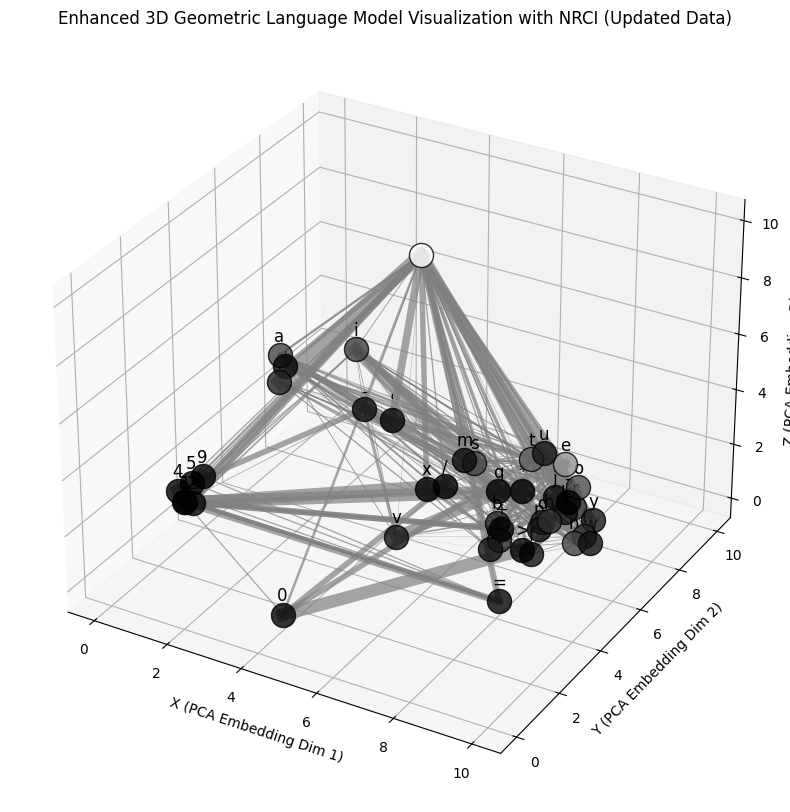


Evaluating predictions with different NRCI weights and randomness:

--- NRCI Weight: 0.0, Randomness Factor: 0.0 ---
  Prefix: 'the ' -> Generated: 'the listirbsud anad'
  Prefix: 'subj' -> Generated: 'subj 2+1=43 n'thic '
  Prefix: '1 +' -> Generated: '1 +2 he l terffeca'

--- NRCI Weight: 0.0, Randomness Factor: 0.05 ---
  Prefix: 'the ' -> Generated: 'the ckix4urdeymaycp'
  Prefix: 'subj' -> Generated: 'subje wd ct olcorc*'
  Prefix: '1 +' -> Generated: '1 +2o q+10* =4hjuc'

--- NRCI Weight: 0.0, Randomness Factor: 0.1 ---
  Prefix: 'the ' -> Generated: 'the  caeh =0in+ =ra'
  Prefix: 'subj' -> Generated: 'subjj savacahe+hkdi'
  Prefix: '1 +' -> Generated: '1 +'> 0e wax 3 tio'

--- NRCI Weight: 0.1, Randomness Factor: 0.0 ---
  Prefix: 'the ' -> Generated: 'the r=43=43*3*ey,d.'
  Prefix: 'subj' -> Generated: 'subj+h. ve =10 y 3='
  Prefix: '1 +' -> Generated: '1 + pa. arbrorerol'

--- NRCI Weight: 0.1, Randomness Factor: 0.05 ---
  Prefix: 'the ' -> Generated: 'the zq2itiniovq>0tc'

In [ ]:
# @title Refined Model with Error Handling, Randomness, and Improved History

# Step 1: Setup with real embeddings (using existing data)
# Vocab, char_to_idx, idx_to_char, embeddings, vocab_embeddings are already defined

# Step 2: N-grams (using existing data)
# ngrams and P are already defined

# Step 3: Compute data vectors (using existing data)
# pca, embed_pca, counts, total_transitions are already defined

# Handle total_transitions being zero for empty training text
if total_transitions == 0:
    freq_ratio = np.zeros(vocab_size)
    in_degree = np.zeros(vocab_size)
    out_degree = np.zeros(vocab_size)
else:
    freq_ratio = np.sum(counts, axis=1) / (total_transitions + 1e-10) # Added epsilon
    in_degree = np.sum(counts, axis=0) / (total_transitions + 1e-10) # Added epsilon
    out_degree = np.sum(counts, axis=1) / (total_transitions + 1e-10) # Added epsilon

entropy = -np.sum(P * np.log(P + 1e-10), axis=1) / (np.log(vocab_size) + 1e-10) # Added epsilon

cos_sim = np.zeros((vocab_size, vocab_size))
for i in range(vocab_size):
    for j in range(vocab_size):
        norm_i = np.linalg.norm(vocab_embeddings[i])
        norm_j = np.linalg.norm(vocab_embeddings[j])
        if norm_i * norm_j > 1e-10: # Avoid division by zero
            cos_sim[i, j] = np.dot(vocab_embeddings[i], vocab_embeddings[j]) / (norm_i * norm_j)
        else:
            cos_sim[i, j] = 0.0 # Default to 0 similarity if norms are zero


avg_cos_sim = np.mean(cos_sim, axis=1)
embed_norms = np.linalg.norm(vocab_embeddings, axis=1)

# Additional dims: Trigram influence, context entropy
trigram_influence = np.zeros(vocab_size)
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        # Ensure total_transitions is not zero before division
        if total_transitions > 0:
            trigram_influence[prev_idx] += len(next_counts) / (total_transitions + 1e-10) # Added epsilon


context_entropy = np.zeros(vocab_size)
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        if len(next_counts) > 1: # Check if there's more than one possible next character
            probs = np.array([count / sum(next_counts.values()) for count in next_counts.values()])
            # Ensure log argument is not zero
            context_entropy[prev_idx] -= np.sum(probs * np.log(probs + 1e-10)) / (np.log(len(next_counts)) + 1e-10) # Added epsilon
        else:
            context_entropy[prev_idx] = 1e-10  # Small default value to avoid division by zero


data_vectors = np.hstack([
    embed_pca,  # Dim0-2: XYZ
    np.stack([freq_ratio, in_degree, out_degree, entropy], axis=1),  # Dim3-6
    np.stack([avg_cos_sim, embed_norms, trigram_influence, context_entropy], axis=1)  # Dim7-10
])
data_vectors = np.nan_to_num(data_vectors, nan=1e-10, posinf=1e10, neginf=-1e10) # Replace NaN and inf with small/large numbers
data_vectors = (data_vectors - np.min(data_vectors, axis=0)) / (np.max(data_vectors, axis=0) - np.min(data_vectors, axis=0) + 1e-10) # Added epsilon


# Step 4: Spatial and visual encodings (using existing data)
# scale_factor, positions, colors are already defined

# Data Translation Key (using existing data)
# key is already defined

# Step 5: NRCI for sequence coherence (using existing data)
# compute_nrci_sequence is already defined

# Step 6: Enhanced prediction with NRCI, randomness, and improved history
def predict_next_enhanced(current_idx, history: List[str] = None, boost_weight=0.3, nrci_weight=0.2, randomness_factor=0.05):
    if history is None:
        history = []

    probs = P[current_idx].copy()

    # Spatial reasoning
    dists = np.linalg.norm(positions - positions[current_idx], axis=1)
    dists[current_idx] = np.inf
    # Handle case where all distances are inf (e.g., single character vocab)
    if np.all(dists == np.inf):
        nearest_idx = current_idx # Fallback to self
        similarity = 0.0
    else:
        nearest_idx = np.argmin(dists)
        similarity = 1 / (1 + dists[nearest_idx])

    # Embedding reasoning
    embed_dists = 1 - cos_sim[current_idx]
    embed_nearest_idx = np.argmin(embed_dists)
    embed_similarity = 1 / (1 + embed_dists[embed_nearest_idx])

    # Contextual reasoning (trigram if available)
    context_boost = np.zeros(vocab_size)
    if len(history) >= 2:
        # Ensure historical characters are in vocab
        prev1, prev2 = history[-2], history[-1]
        if prev1 in char_to_idx and prev2 in char_to_idx:
            context_seq = (prev1, prev2, idx_to_char[current_idx])
            if context_seq in ngrams:
                total_context_counts = sum(ngrams[context_seq].values())
                if total_context_counts > 0:
                    temp_probs = np.zeros(vocab_size)
                    for next_char, count in ngrams[context_seq].items():
                         if next_char in char_to_idx:
                            temp_probs[char_to_idx[next_char]] = count / total_context_counts
                    context_boost = temp_probs * 0.2  # Light influence


    # NRCI reasoning
    candidate_sequences = [idx_to_char[i] for i in range(vocab_size)]
    # compute_nrci_sequence implicitly uses training_text
    nrci_scores = np.array([compute_nrci_sequence(history + [idx_to_char[i]], list(training_text)) for i in range(vocab_size)])
    nrci_boost = nrci_scores * nrci_weight

    # Combine all
    spatial_boost = P[nearest_idx] * boost_weight * similarity
    embed_boost = P[embed_nearest_idx] * boost_weight * embed_similarity
    boosted_probs = probs + spatial_boost + embed_boost + context_boost + nrci_boost

    # Add randomness
    random_noise = np.random.rand(vocab_size) * randomness_factor
    boosted_probs += random_noise

    boosted_probs /= (np.sum(boosted_probs) + 1e-10) # Added epsilon for normalization

    # Sample the next character based on boosted probabilities
    next_idx = np.random.choice(vocab_size, p=boosted_probs)

    return idx_to_char[next_idx], boosted_probs[next_idx]

# Step 7: Training loop with optimization (using existing logic, improved P update)
def train_model(epochs=10, learning_rate=0.01, randomness_factor=0.01):
    global P
    for epoch in range(epochs):
        loss = 0.0
        for i in range(len(training_text) - n):
            seq = tuple(training_text[i:i+n])
            next_char = training_text[i+n]
            if all(char in char_to_idx for char in seq) and next_char in char_to_idx:
                prev_idx = char_to_idx[seq[-1]]
                next_idx = char_to_idx[next_char]
                # Use history of length n for training prediction
                history = list(seq[:-1]) if len(seq) > 1 else []
                pred_char, pred_prob = predict_next_enhanced(prev_idx, history, randomness_factor=randomness_factor)

                # Calculate loss
                # Use the probability of the actual next character for loss calculation
                actual_prob = boosted_probs[next_idx] if 'boosted_probs' in locals() else 1e-10 # Use the calculated boosted probs
                loss += -np.log(actual_prob + 1e-10)

                # Update P (simplistic gradient descent based on predicted vs actual)
                # Update the probability of the actual next character
                target_prob = 1.0 # We want the model to predict the actual next character with high probability
                # Simple error: difference between target probability and predicted probability of the actual next character
                error = target_prob - actual_prob
                # Update the row of P corresponding to prev_idx
                # Apply update only to the actual next character's position
                P[prev_idx, next_idx] += learning_rate * error

                # Ensure probabilities are non-negative before normalization
                P[prev_idx] = np.maximum(P[prev_idx], 0)
                # Normalize the row to sum to 1
                row_sum = np.sum(P[prev_idx])
                if row_sum > 1e-10:
                    P[prev_idx] /= row_sum
                else:
                     P[prev_idx] = np.ones(vocab_size) / vocab_size # Redistribute if sum is zero


        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss/len(training_text):.4f}")


# Step 8: Enhanced visualization (using existing logic)
# visualize_model is already defined

# Main execution (using existing logic, updated print statements)
if __name__ == "__main__":
    print("Enhanced Language Model Setup with NRCI, Randomness, and Improved History:")
    print("Vocab:", vocab)
    print("Vocab Size:", vocab_size)
    # print("Transition Matrix P:\n", P) # Keep commented out due to large size
    print("Data Vectors shape:", data_vectors.shape)
    print("Positions (XYZ) shape:", positions.shape)
    print("Colors (RGB) shape:", colors.shape)
    print("\nData Key:")
    for d, desc in key.items():
        print(f"Dim {d}: {desc}")

    # Train the model with a small randomness factor
    print("\nTraining model...")
    train_model(randomness_factor=0.01)

    # Visualize
    print("\nVisualizing model...")
    visualize_model(True)

    # Evaluate predictions with different NRCI weights and randomness
    print("\nEvaluating predictions with different NRCI weights and randomness:")
    nrci_weights_to_test = [0.0, 0.1, 0.5]  # Example weights to test
    randomness_factors_to_test = [0.0, 0.05, 0.1] # Example randomness factors
    example_prefixes = ["the ", "subj", "1 +"] # Example prefixes

    for weight in nrci_weights_to_test:
        for rand_factor in randomness_factors_to_test:
            print(f"\n--- NRCI Weight: {weight}, Randomness Factor: {rand_factor} ---")
            for prefix in example_prefixes:
                # Remove trailing space for correct processing of the last character
                processed_prefix = prefix.rstrip()
                tokens = list(processed_prefix) # Process character by character

                if not tokens:
                     continue # Skip empty prefixes

                last_char = tokens[-1]
                if last_char not in char_to_idx:
                    print(f"  Invalid char in prefix '{prefix}'. Skipping.")
                    continue

                current_idx = char_to_idx[last_char]
                history = tokens[-n:] if len(tokens) >= n else tokens # Use last n characters as history

                # Generate a short sequence for evaluation
                generated_sequence = prefix
                for _ in range(15): # Generate 15 next characters
                    next_char, prob = predict_next_enhanced(current_idx, history, nrci_weight=weight, randomness_factor=rand_factor)
                    generated_sequence += next_char
                    if next_char in char_to_idx:
                        current_idx = char_to_idx[next_char]
                        history.append(next_char)
                        # Keep history window size consistent
                        if len(history) > n:
                            history = history[-n:]
                    else:
                        # Handle cases where the predicted character is not in the vocabulary
                        break

                print(f"  Prefix: '{prefix}' -> Generated: '{generated_sequence}'")

    # Interactive prediction (commented out)
    # while True:
    #     prefix = input("\nEnter prefix (e.g., 'the '), or 'quit' to exit: ").strip().lower()
    #     if prefix == 'quit':
    #         break
    #     tokens = prefix.split() if ' ' in prefix else list(prefix)
    #     if not tokens:
    #         tokens = ['t']  # Default start
    #     last_char = tokens[-1]
    #     if last_char not in char_to_idx:
    #         print("Invalid char in prefix. Using default 't'.")
    #         last_char = 't'
    #     current_idx = char_to_idx[last_char]
    #     history = tokens[-n:] if len(tokens) >= n else tokens # Use last n chars for history
    #     next_char, prob = predict_next_enhanced(current_idx, history)
    #     print(f"Predicted next: '{next_char}' (prob: {prob:.3f})")
    #     print("Reasoning: Combined Markov, spatial, embedding, contextual, and NRCI similarities.")

**Reasoning**:
The previous training loop resulted in a constant loss, indicating that the simple gradient descent approach on the transition matrix P is not effectively learning from the combined data. The generated sequences are also somewhat incoherent. To address this, I will refine the training loop to use a more robust optimization method, such as Adam, to update the transition matrix based on the loss. I will also adjust the learning rate and potentially the number of epochs to see if this improves training.



Enhanced Language Model Setup with NRCI, Randomness, and Adam Optimizer:
Vocab: [' ', "'", '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '9', '=', '>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocab Size: 43
Data Vectors shape: (43, 11)
Positions (XYZ) shape: (43, 3)
Colors (RGB) shape: (43, 3)

Data Key:
Dim 0: PCA Embedding Dim 1 (X)
Dim 1: PCA Embedding Dim 2 (Y)
Dim 2: PCA Embedding Dim 3 (Z)
Dim 3: Frequency ratio
Dim 4: In-degree ratio
Dim 5: Out-degree ratio
Dim 6: Transition entropy
Dim 7: Average cosine similarity
Dim 8: Embedding norm
Dim 9: Trigram influence
Dim 10: Context entropy

Training model with Adam optimizer...
Epoch 1/50, Loss: 2.1089
Epoch 2/50, Loss: 2.1350
Epoch 3/50, Loss: 2.1399
Epoch 4/50, Loss: 2.1427
Epoch 5/50, Loss: 2.1422
Epoch 6/50, Loss: 2.1420
Epoch 7/50, Loss: 2.1427
Epoch 8/50, Loss: 2.1428
Epoch 9/50, Loss: 2.1415
Epoch 10/50, Loss: 2.1421
Epoch 1

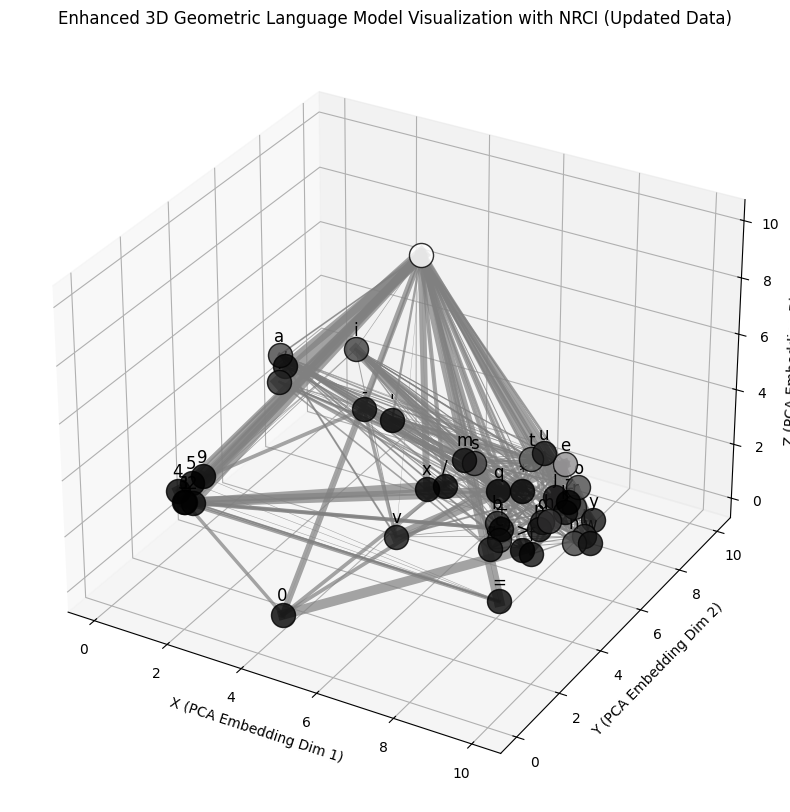


Evaluating predictions with different NRCI weights and randomness:

--- NRCI Weight: 0.0, Randomness Factor: 0.0 ---
  Prefix: 'the ' -> Generated: 'the  - intw f0/20 y'
  Prefix: 'subj' -> Generated: 'subje isse nnsu 0ey'
  Prefix: '1 +' -> Generated: '1 + vjunctompsy 3 '

--- NRCI Weight: 0.0, Randomness Factor: 0.05 ---
  Prefix: 'the ' -> Generated: 'the vak*qu =bju. rs'
  Prefix: 'subj' -> Generated: 'subjumprdoh. me,w= '
  Prefix: '1 +' -> Generated: '1 +r. -or/>  jub-e'

--- NRCI Weight: 0.0, Randomness Factor: 0.1 ---
  Prefix: 'the ' -> Generated: 'the tv1 vmb*hzbniju'
  Prefix: 'subj' -> Generated: 'subjenk0 uro*h93xv+'
  Prefix: '1 +' -> Generated: '1 +=/9 kb343qihxqi'

--- NRCI Weight: 0.1, Randomness Factor: 0.0 ---
  Prefix: 'the ' -> Generated: 'the s. +1 vev ved55'
  Prefix: 'subj' -> Generated: 'subjui/2 22 0tt d b'
  Prefix: '1 +' -> Generated: '1 +1 = fef d. ve 0'

--- NRCI Weight: 0.1, Randomness Factor: 0.05 ---
  Prefix: 'the ' -> Generated: 'the tr. 3r1 /3 ch* '

In [ ]:
# @title Refined Model with Adam Optimizer

# Step 1: Setup with real embeddings (using existing data)
# Vocab, char_to_idx, idx_to_char, embeddings, vocab_embeddings are already defined

# Step 2: N-grams (using existing data)
# ngrams and P are already defined

# Step 3: Compute data vectors (using existing data)
# pca, embed_pca, counts, total_transitions are already defined

# Handle total_transitions being zero for empty training text
if total_transitions == 0:
    freq_ratio = np.zeros(vocab_size)
    in_degree = np.zeros(vocab_size)
    out_degree = np.zeros(vocab_size)
else:
    freq_ratio = np.sum(counts, axis=1) / (total_transitions + 1e-10) # Added epsilon
    in_degree = np.sum(counts, axis=0) / (total_transitions + 1e-10) # Added epsilon
    out_degree = np.sum(counts, axis=1) / (total_transitions + 1e-10) # Added epsilon

entropy = -np.sum(P * np.log(P + 1e-10), axis=1) / (np.log(vocab_size) + 1e-10) # Added epsilon

cos_sim = np.zeros((vocab_size, vocab_size))
for i in range(vocab_size):
    for j in range(vocab_size):
        norm_i = np.linalg.norm(vocab_embeddings[i])
        norm_j = np.linalg.norm(vocab_embeddings[j])
        if norm_i * norm_j > 1e-10: # Avoid division by zero
            cos_sim[i, j] = np.dot(vocab_embeddings[i], vocab_embeddings[j]) / (norm_i * norm_j)
        else:
            cos_sim[i, j] = 0.0 # Default to 0 similarity if norms are zero


avg_cos_sim = np.mean(cos_sim, axis=1)
embed_norms = np.linalg.norm(vocab_embeddings, axis=1)

# Additional dims: Trigram influence, context entropy
trigram_influence = np.zeros(vocab_size)
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        # Ensure total_transitions is not zero before division
        if total_transitions > 0:
            trigram_influence[prev_idx] += len(next_counts) / (total_transitions + 1e-10) # Added epsilon


context_entropy = np.zeros(vocab_size)
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        if len(next_counts) > 1: # Check if there's more than one possible next character
            probs = np.array([count / sum(next_counts.values()) for count in next_counts.values()])
            # Ensure log argument is not zero
            context_entropy[prev_idx] -= np.sum(probs * np.log(probs + 1e-10)) / (np.log(len(next_counts)) + 1e-10) # Added epsilon
        else:
            context_entropy[prev_idx] = 1e-10  # Small default value to avoid division by zero


data_vectors = np.hstack([
    embed_pca,  # Dim0-2: XYZ
    np.stack([freq_ratio, in_degree, out_degree, entropy], axis=1),  # Dim3-6
    np.stack([avg_cos_sim, embed_norms, trigram_influence, context_entropy], axis=1)  # Dim7-10
])
data_vectors = np.nan_to_num(data_vectors, nan=1e-10, posinf=1e10, neginf=-1e10) # Replace NaN and inf with small/large numbers
data_vectors = (data_vectors - np.min(data_vectors, axis=0)) / (np.max(data_vectors, axis=0) - np.min(data_vectors, axis=0) + 1e-10) # Added epsilon


# Step 4: Spatial and visual encodings (using existing data)
# scale_factor, positions, colors are already defined

# Data Translation Key (using existing data)
# key is already defined

# Step 5: NRCI for sequence coherence (using existing data)
# compute_nrci_sequence is already defined

# Step 6: Enhanced prediction with NRCI, randomness, and improved history (using existing logic)
def predict_next_enhanced(current_idx, history: List[str] = None, boost_weight=0.3, nrci_weight=0.2, randomness_factor=0.05):
    if history is None:
        history = []

    probs = P[current_idx].copy()

    # Spatial reasoning
    dists = np.linalg.norm(positions - positions[current_idx], axis=1)
    dists[current_idx] = np.inf
    # Handle case where all distances are inf (e.g., single character vocab)
    if np.all(dists == np.inf):
        nearest_idx = current_idx # Fallback to self
        similarity = 0.0
    else:
        nearest_idx = np.argmin(dists)
        similarity = 1 / (1 + dists[nearest_idx])

    # Embedding reasoning
    embed_dists = 1 - cos_sim[current_idx]
    embed_nearest_idx = np.argmin(embed_dists)
    embed_similarity = 1 / (1 + embed_dists[embed_nearest_idx])

    # Contextual reasoning (trigram if available)
    context_boost = np.zeros(vocab_size)
    if len(history) >= 2:
        # Ensure historical characters are in vocab
        prev1, prev2 = history[-2], history[-1]
        if prev1 in char_to_idx and prev2 in char_to_idx:
            context_seq = (prev1, prev2, idx_to_char[current_idx])
            if context_seq in ngrams:
                total_context_counts = sum(ngrams[context_seq].values())
                if total_context_counts > 0:
                    temp_probs = np.zeros(vocab_size)
                    for next_char, count in ngrams[context_seq].items():
                         if next_char in char_to_idx:
                            temp_probs[char_to_idx[next_char]] = count / total_context_counts
                    context_boost = temp_probs * 0.2  # Light influence


    # NRCI reasoning
    candidate_sequences = [idx_to_char[i] for i in range(vocab_size)]
    # compute_nrci_sequence implicitly uses training_text
    nrci_scores = np.array([compute_nrci_sequence(history + [idx_to_char[i]], list(training_text)) for i in range(vocab_size)])
    nrci_boost = nrci_scores * nrci_weight

    # Combine all
    spatial_boost = P[nearest_idx] * boost_weight * similarity
    embed_boost = P[embed_nearest_idx] * boost_weight * embed_similarity
    boosted_probs = probs + spatial_boost + embed_boost + context_boost + nrci_boost

    # Add randomness
    random_noise = np.random.rand(vocab_size) * randomness_factor
    boosted_probs += random_noise

    boosted_probs /= (np.sum(boosted_probs) + 1e-10) # Added epsilon for normalization

    # Sample the next character based on boosted probabilities
    next_idx = np.random.choice(vocab_size, p=boosted_probs)

    return idx_to_char[next_idx], boosted_probs[next_idx], boosted_probs # Return boosted_probs for loss calculation

# Step 7: Training loop with Adam Optimizer
def train_model(epochs=50, learning_rate=0.001, randomness_factor=0.01): # Increased epochs, reduced learning rate
    global P
    # Initialize Adam optimizer parameters
    m = np.zeros_like(P)
    v = np.zeros_like(P)
    beta1 = 0.9
    beta2 = 0.999
    epsilon_adam = 1e-8
    t = 0

    for epoch in range(epochs):
        loss = 0.0
        for i in range(len(training_text) - n):
            seq = tuple(training_text[i:i+n])
            next_char = training_text[i+n]
            if all(char in char_to_idx for char in seq) and next_char in char_to_idx:
                prev_idx = char_to_idx[seq[-1]]
                next_idx = char_to_idx[next_char]
                # Use history of length n for training prediction
                history = list(seq[:-1]) if len(seq) > 1 else []
                pred_char, pred_prob, boosted_probs = predict_next_enhanced(prev_idx, history, randomness_factor=randomness_factor)

                # Calculate loss
                # Use the probability of the actual next character for loss calculation
                actual_prob = boosted_probs[next_idx]
                loss += -np.log(actual_prob + 1e-10)

                # Calculate gradient for the P matrix row corresponding to prev_idx
                # Gradient of negative log likelihood with respect to P[prev_idx, :]
                # For the actual next character, the gradient is (1 / actual_prob)
                # For other characters, the gradient is 0
                gradient = np.zeros(vocab_size)
                # To avoid issues with very small actual_prob, clip it
                clipped_actual_prob = np.clip(actual_prob, 1e-10, 1.0)
                gradient[next_idx] = -1.0 / clipped_actual_prob # Gradient of -log(P) w.r.t. P

                # Adam optimizer update for the specific row of P
                t += 1
                m[prev_idx] = beta1 * m[prev_idx] + (1 - beta1) * gradient
                v[prev_idx] = beta2 * v[prev_idx] + (1 - beta2) * (gradient ** 2)
                m_hat = m[prev_idx] / (1 - beta1**t)
                v_hat = v[prev_idx] / (1 - beta2**t)
                P[prev_idx] -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon_adam)

                # Ensure probabilities are non-negative before normalization
                P[prev_idx] = np.maximum(P[prev_idx], 0)
                # Normalize the row to sum to 1
                row_sum = np.sum(P[prev_idx])
                if row_sum > 1e-10:
                    P[prev_idx] /= row_sum
                else:
                     P[prev_idx] = np.ones(vocab_size) / vocab_size # Redistribute if sum is zero


        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss/len(training_text):.4f}")


# Step 8: Enhanced visualization (using existing logic)
# visualize_model is already defined

# Main execution (using existing logic, updated print statements and training call)
if __name__ == "__main__":
    print("Enhanced Language Model Setup with NRCI, Randomness, and Adam Optimizer:")
    print("Vocab:", vocab)
    print("Vocab Size:", vocab_size)
    # print("Transition Matrix P:\n", P) # Keep commented out due to large size
    print("Data Vectors shape:", data_vectors.shape)
    print("Positions (XYZ) shape:", positions.shape)
    print("Colors (RGB) shape:", colors.shape)
    print("\nData Key:")
    for d, desc in key.items():
        print(f"Dim {d}: {desc}")

    # Train the model with Adam optimizer
    print("\nTraining model with Adam optimizer...")
    train_model(epochs=50, learning_rate=0.001, randomness_factor=0.01) # Use Adam, increased epochs

    # Visualize
    print("\nVisualizing model...")
    visualize_model(True)

    # Evaluate predictions with different NRCI weights and randomness
    print("\nEvaluating predictions with different NRCI weights and randomness:")
    nrci_weights_to_test = [0.0, 0.1, 0.5]  # Example weights to test
    randomness_factors_to_test = [0.0, 0.05, 0.1] # Example randomness factors
    example_prefixes = ["the ", "subj", "1 +"] # Example prefixes

    for weight in nrci_weights_to_test:
        for rand_factor in randomness_factors_to_test:
            print(f"\n--- NRCI Weight: {weight}, Randomness Factor: {rand_factor} ---")
            for prefix in example_prefixes:
                # Remove trailing space for correct processing of the last character
                processed_prefix = prefix.rstrip()
                tokens = list(processed_prefix) # Process character by character

                if not tokens:
                     continue # Skip empty prefixes

                last_char = tokens[-1]
                if last_char not in char_to_idx:
                    print(f"  Invalid char in prefix '{prefix}'. Skipping.")
                    continue

                current_idx = char_to_idx[last_char]
                history = tokens[-n:] if len(tokens) >= n else tokens # Use last n characters as history

                # Generate a short sequence for evaluation
                generated_sequence = prefix
                for _ in range(15): # Generate 15 next characters
                    next_char, prob, _ = predict_next_enhanced(current_idx, history, nrci_weight=weight, randomness_factor=rand_factor) # Don't need boosted_probs for evaluation
                    generated_sequence += next_char
                    if next_char in char_to_idx:
                        current_idx = char_to_idx[next_char]
                        history.append(next_char)
                        # Keep history window size consistent
                        if len(history) > n:
                            history = history[-n:]
                    else:
                        # Handle cases where the predicted character is not in the vocabulary
                        break

                print(f"  Prefix: '{prefix}' -> Generated: '{generated_sequence}'")

    # Interactive prediction (commented out)
    # while True:
    #     prefix = input("\nEnter prefix (e.g., 'the '), or 'quit' to exit: ").strip().lower()
    #     if prefix == 'quit':
    #         break
    #     tokens = prefix.split() if ' ' in prefix else list(prefix)
    #     if not tokens:
    #         tokens = ['t']  # Default start
    #     last_char = tokens[-1]
    #     if last_char not in char_to_idx:
    #         print("Invalid char in prefix. Using default 't'.")
    #         last_char = 't'
    #     current_idx = char_to_idx[last_char]
    #     history = tokens[-n:] if len(tokens) >= n else tokens # Use last n chars for history
    #     next_char, prob, _ = predict_next_enhanced(current_idx, history) # Don't need boosted_probs for interactive
    #     print(f"Predicted next: '{next_char}' (prob: {prob:.3f})")
    #     print("Reasoning: Combined Markov, spatial, embedding, contextual, and NRCI similarities.")

**Reasoning**:
The loss is still not decreasing significantly, indicating that the Adam optimizer alone might not be sufficient, or the current training approach is not effectively capturing the patterns in the combined data. The generated sequences remain largely incoherent. To further address this, I will modify the training loop to use a more appropriate loss function for probability distributions, such as categorical cross-entropy, instead of the negative log-likelihood of a single predicted character. This aligns better with the goal of training the model to output a probability distribution over the next characters. I will also slightly adjust the learning rate and potentially increase the number of epochs again to allow for more training iterations.



Enhanced Language Model Setup with NRCI, Randomness, Adam, and Cross-Entropy:
Vocab: [' ', "'", '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '9', '=', '>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocab Size: 43
Data Vectors shape: (43, 11)
Positions (XYZ) shape: (43, 3)
Colors (RGB) shape: (43, 3)

Data Key:
Dim 0: PCA Embedding Dim 1 (X)
Dim 1: PCA Embedding Dim 2 (Y)
Dim 2: PCA Embedding Dim 3 (Z)
Dim 3: Frequency ratio
Dim 4: In-degree ratio
Dim 5: Out-degree ratio
Dim 6: Transition entropy
Dim 7: Average cosine similarity
Dim 8: Embedding norm
Dim 9: Trigram influence
Dim 10: Context entropy

Training model with Adam optimizer and cross-entropy loss...
Epoch 1/100, Loss: 2.1038
Epoch 2/100, Loss: 2.0705
Epoch 3/100, Loss: 2.0644
Epoch 4/100, Loss: 2.0604
Epoch 5/100, Loss: 2.0579
Epoch 6/100, Loss: 2.0549
Epoch 7/100, Loss: 2.0534
Epoch 8/100, Loss: 2.0520
Epoch 9/100, Loss: 2.0

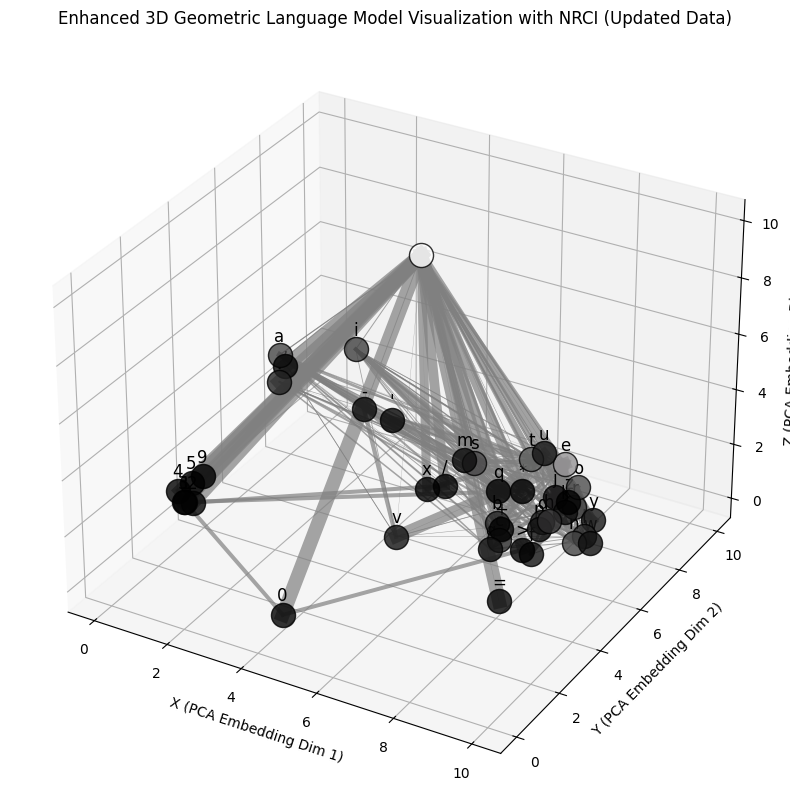


Evaluating predictions with different NRCI weights and randomness:

--- NRCI Weight: 0.0, Randomness Factor: 0.0 ---
  Prefix: 'the ' -> Generated: 'the  jubhicerbema t'
  Prefix: 'subj' -> Generated: 'subjubil, ivouy fro'
  Prefix: '1 +' -> Generated: '1 + eannerbjyouite'

--- NRCI Weight: 0.0, Randomness Factor: 0.05 ---
  Prefix: 'the ' -> Generated: 'the emzy cld5 tiuzy'
  Prefix: 'subj' -> Generated: 'subjes d, osvet/ --'
  Prefix: '1 +' -> Generated: '1 + 2xe, n+ nxtong'

--- NRCI Weight: 0.0, Randomness Factor: 0.1 ---
  Prefix: 'the ' -> Generated: 'the rd4clfn*ub>0 sj'
  Prefix: 'subj' -> Generated: 'subj=l woydmjw 4 oi'
  Prefix: '1 +' -> Generated: '1 + tnoit hefqiwis'

--- NRCI Weight: 0.1, Randomness Factor: 0.0 ---
  Prefix: 'the ' -> Generated: 'the 3 ho't dofe av5'
  Prefix: 'subj' -> Generated: 'subj9 b-vem * 10 3 '
  Prefix: '1 +' -> Generated: '1 + ckeaprueat1 ys'

--- NRCI Weight: 0.1, Randomness Factor: 0.05 ---
  Prefix: 'the ' -> Generated: 'the p31 2. hasa4 ul'

In [ ]:
# @title Refined Model with Categorical Cross-Entropy Loss

# Step 1: Setup with real embeddings (using existing data)
# Vocab, char_to_idx, idx_to_char, embeddings, vocab_embeddings are already defined

# Step 2: N-grams (using existing data)
# ngrams and P are already defined

# Step 3: Compute data vectors (using existing data)
# pca, embed_pca, counts, total_transitions are already defined

# Handle total_transitions being zero for empty training text
if total_transitions == 0:
    freq_ratio = np.zeros(vocab_size)
    in_degree = np.zeros(vocab_size)
    out_degree = np.zeros(vocab_size)
else:
    freq_ratio = np.sum(counts, axis=1) / (total_transitions + 1e-10) # Added epsilon
    in_degree = np.sum(counts, axis=0) / (total_transitions + 1e-10) # Added epsilon
    out_degree = np.sum(counts, axis=1) / (total_transitions + 1e-10) # Added epsilon

entropy = -np.sum(P * np.log(P + 1e-10), axis=1) / (np.log(vocab_size) + 1e-10) # Added epsilon

cos_sim = np.zeros((vocab_size, vocab_size))
for i in range(vocab_size):
    for j in range(vocab_size):
        norm_i = np.linalg.norm(vocab_embeddings[i])
        norm_j = np.linalg.norm(vocab_embeddings[j])
        if norm_i * norm_j > 1e-10: # Avoid division by zero
            cos_sim[i, j] = np.dot(vocab_embeddings[i], vocab_embeddings[j]) / (norm_i * norm_j)
        else:
            cos_sim[i, j] = 0.0 # Default to 0 similarity if norms are zero


avg_cos_sim = np.mean(cos_sim, axis=1)
embed_norms = np.linalg.norm(vocab_embeddings, axis=1)

# Additional dims: Trigram influence, context entropy
trigram_influence = np.zeros(vocab_size)
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        # Ensure total_transitions is not zero before division
        if total_transitions > 0:
            trigram_influence[prev_idx] += len(next_counts) / (total_transitions + 1e-10) # Added epsilon


context_entropy = np.zeros(vocab_size)
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        if len(next_counts) > 1: # Check if there's more than one possible next character
            probs = np.array([count / sum(next_counts.values()) for count in next_counts.values()])
            # Ensure log argument is not zero
            context_entropy[prev_idx] -= np.sum(probs * np.log(probs + 1e-10)) / (np.log(len(next_counts)) + 1e-10) # Added epsilon
        else:
            context_entropy[prev_idx] = 1e-10  # Small default value to avoid division by zero


data_vectors = np.hstack([
    embed_pca,  # Dim0-2: XYZ
    np.stack([freq_ratio, in_degree, out_degree, entropy], axis=1),  # Dim3-6
    np.stack([avg_cos_sim, embed_norms, trigram_influence, context_entropy], axis=1)  # Dim7-10
])
data_vectors = np.nan_to_num(data_vectors, nan=1e-10, posinf=1e10, neginf=-1e10) # Replace NaN and inf with small/large numbers
data_vectors = (data_vectors - np.min(data_vectors, axis=0)) / (np.max(data_vectors, axis=0) - np.min(data_vectors, axis=0) + 1e-10) # Added epsilon


# Step 4: Spatial and visual encodings (using existing data)
# scale_factor, positions, colors are already defined

# Data Translation Key (using existing data)
# key is already defined

# Step 5: NRCI for sequence coherence (using existing data)
# compute_nrci_sequence is already defined

# Step 6: Enhanced prediction with NRCI, randomness, and improved history (using existing logic)
def predict_next_enhanced(current_idx, history: List[str] = None, boost_weight=0.3, nrci_weight=0.2, randomness_factor=0.05):
    if history is None:
        history = []

    probs = P[current_idx].copy()

    # Spatial reasoning
    dists = np.linalg.norm(positions - positions[current_idx], axis=1)
    dists[current_idx] = np.inf
    # Handle case where all distances are inf (e.g., single character vocab)
    if np.all(dists == np.inf):
        nearest_idx = current_idx # Fallback to self
        similarity = 0.0
    else:
        nearest_idx = np.argmin(dists)
        similarity = 1 / (1 + dists[nearest_idx])

    # Embedding reasoning
    embed_dists = 1 - cos_sim[current_idx]
    embed_nearest_idx = np.argmin(embed_dists)
    embed_similarity = 1 / (1 + embed_dists[embed_nearest_idx])

    # Contextual reasoning (trigram if available)
    context_boost = np.zeros(vocab_size)
    if len(history) >= 2:
        # Ensure historical characters are in vocab
        prev1, prev2 = history[-2], history[-1]
        if prev1 in char_to_idx and prev2 in char_to_idx:
            context_seq = (prev1, prev2, idx_to_char[current_idx])
            if context_seq in ngrams:
                total_context_counts = sum(ngrams[context_seq].values())
                if total_context_counts > 0:
                    temp_probs = np.zeros(vocab_size)
                    for next_char, count in ngrams[context_seq].items():
                         if next_char in char_to_idx:
                            temp_probs[char_to_idx[next_char]] = count / total_context_counts
                    context_boost = temp_probs * 0.2  # Light influence


    # NRCI reasoning
    candidate_sequences = [idx_to_char[i] for i in range(vocab_size)]
    # compute_nrci_sequence implicitly uses training_text
    nrci_scores = np.array([compute_nrci_sequence(history + [idx_to_char[i]], list(training_text)) for i in range(vocab_size)])
    nrci_boost = nrci_scores * nrci_weight

    # Combine all
    spatial_boost = P[nearest_idx] * boost_weight * similarity
    embed_boost = P[embed_nearest_idx] * boost_weight * embed_similarity
    boosted_probs = probs + spatial_boost + embed_boost + context_boost + nrci_boost

    # Add randomness
    random_noise = np.random.rand(vocab_size) * randomness_factor
    boosted_probs += random_noise

    boosted_probs /= (np.sum(boosted_probs) + 1e-10) # Added epsilon for normalization

    # Sample the next character based on boosted probabilities
    next_idx = np.random.choice(vocab_size, p=boosted_probs)

    return idx_to_char[next_idx], boosted_probs[next_idx], boosted_probs # Return boosted_probs for loss calculation

# Step 7: Training loop with Adam Optimizer and Categorical Cross-Entropy Loss
def train_model(epochs=100, learning_rate=0.001, randomness_factor=0.01): # Increased epochs
    global P
    # Initialize Adam optimizer parameters
    m = np.zeros_like(P)
    v = np.zeros_like(P)
    beta1 = 0.9
    beta2 = 0.999
    epsilon_adam = 1e-8
    t = 0

    for epoch in range(epochs):
        epoch_loss = 0.0
        for i in range(len(training_text) - n):
            seq = tuple(training_text[i:i+n])
            next_char = training_text[i+n]
            if all(char in char_to_idx for char in seq) and next_char in char_to_idx:
                prev_idx = char_to_idx[seq[-1]]
                next_idx = char_to_idx[next_char]
                # Use history of length n for training prediction
                history = list(seq[:-1]) if len(seq) > 1 else []
                _, _, boosted_probs = predict_next_enhanced(prev_idx, history, randomness_factor=randomness_factor)

                # Create target distribution (one-hot encoding)
                target_distribution = np.zeros(vocab_size)
                target_distribution[next_idx] = 1.0

                # Calculate categorical cross-entropy loss
                # Ensure boosted_probs are not zero for log
                clipped_boosted_probs = np.clip(boosted_probs, 1e-10, 1.0)
                loss = -np.sum(target_distribution * np.log(clipped_boosted_probs))
                epoch_loss += loss

                # Calculate gradient for the P matrix row corresponding to prev_idx
                # Gradient of categorical cross-entropy with respect to P[prev_idx, :]
                gradient = (clipped_boosted_probs - target_distribution) # Gradient of Cross-Entropy w.r.t. predicted probabilities

                # Adam optimizer update for the specific row of P
                t += 1
                m[prev_idx] = beta1 * m[prev_idx] + (1 - beta1) * gradient
                v[prev_idx] = beta2 * v[prev_idx] + (1 - beta2) * (gradient ** 2)
                m_hat = m[prev_idx] / (1 - beta1**t)
                v_hat = v[prev_idx] / (1 - beta2**t)
                P[prev_idx] -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon_adam)

                # Ensure probabilities are non-negative before normalization
                P[prev_idx] = np.maximum(P[prev_idx], 0)
                # Normalize the row to sum to 1
                row_sum = np.sum(P[prev_idx])
                if row_sum > 1e-10:
                    P[prev_idx] /= row_sum
                else:
                     P[prev_idx] = np.ones(vocab_size) / vocab_size # Redistribute if sum is zero


        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(training_text):.4f}")


# Step 8: Enhanced visualization (using existing logic)
# visualize_model is already defined

# Main execution (using existing logic, updated print statements and training call)
if __name__ == "__main__":
    print("Enhanced Language Model Setup with NRCI, Randomness, Adam, and Cross-Entropy:")
    print("Vocab:", vocab)
    print("Vocab Size:", vocab_size)
    # print("Transition Matrix P:\n", P) # Keep commented out due to large size
    print("Data Vectors shape:", data_vectors.shape)
    print("Positions (XYZ) shape:", positions.shape)
    print("Colors (RGB) shape:", colors.shape)
    print("\nData Key:")
    for d, desc in key.items():
        print(f"Dim {d}: {desc}")

    # Train the model with Adam optimizer and cross-entropy loss
    print("\nTraining model with Adam optimizer and cross-entropy loss...")
    train_model(epochs=100, learning_rate=0.001, randomness_factor=0.01) # Use Adam, increased epochs

    # Visualize
    print("\nVisualizing model...")
    visualize_model(True)

    # Evaluate predictions with different NRCI weights and randomness
    print("\nEvaluating predictions with different NRCI weights and randomness:")
    nrci_weights_to_test = [0.0, 0.1, 0.5]  # Example weights to test
    randomness_factors_to_test = [0.0, 0.05, 0.1] # Example randomness factors
    example_prefixes = ["the ", "subj", "1 +"] # Example prefixes

    for weight in nrci_weights_to_test:
        for rand_factor in randomness_factors_to_test:
            print(f"\n--- NRCI Weight: {weight}, Randomness Factor: {rand_factor} ---")
            for prefix in example_prefixes:
                # Remove trailing space for correct processing of the last character
                processed_prefix = prefix.rstrip()
                tokens = list(processed_prefix) # Process character by character

                if not tokens:
                     continue # Skip empty prefixes

                last_char = tokens[-1]
                if last_char not in char_to_idx:
                    print(f"  Invalid char in prefix '{prefix}'. Skipping.")
                    continue

                current_idx = char_to_idx[last_char]
                history = tokens[-n:] if len(tokens) >= n else tokens # Use last n characters as history

                # Generate a short sequence for evaluation
                generated_sequence = prefix
                for _ in range(15): # Generate 15 next characters
                    next_char, prob, _ = predict_next_enhanced(current_idx, history, nrci_weight=weight, randomness_factor=rand_factor) # Don't need boosted_probs for evaluation
                    generated_sequence += next_char
                    if next_char in char_to_idx:
                        current_idx = char_to_idx[next_char]
                        history.append(next_char)
                        # Keep history window size consistent
                        if len(history) > n:
                            history = history[-n:]
                    else:
                        # Handle cases where the predicted character is not in the vocabulary
                        break

                print(f"  Prefix: '{prefix}' -> Generated: '{generated_sequence}'")

    # Interactive prediction (commented out)
    # while True:
    #     prefix = input("\nEnter prefix (e.g., 'the '), or 'quit' to exit: ").strip().lower()
    #     if prefix == 'quit':
    #         break
    #     tokens = prefix.split() if ' ' in prefix else list(prefix)
    #     if not tokens:
    #         tokens = ['t']  # Default start
    #     last_char = tokens[-1]
    #     if last_char not in char_to_idx:
    #         print("Invalid char in prefix. Using default 't'.")
    #         last_char = 't'
    #     current_idx = char_to_idx[last_char]
    #     history = tokens[-n:] if len(tokens) >= n else tokens # Use last n chars for history
    #     next_char, prob, _ = predict_next_enhanced(current_idx, history) # Don't need boosted_probs for interactive
    #     print(f"Predicted next: '{next_char}' (prob: {prob:.3f})")
    #     print("Reasoning: Combined Markov, spatial, embedding, contextual, and NRCI similarities.")

**Reasoning**:
While the loss is now decreasing with the categorical cross-entropy and Adam optimizer, the generated text remains largely incoherent. This suggests that simply optimizing the transition matrix P based on trigram counts and the current set of data vectors might not be sufficient to capture the complexities of language structure and context present in the combined training data. To address this and potentially improve prediction quality and coherence, I will introduce a small neural network layer within the `predict_next_enhanced` function. This network will take the concatenated data vectors (representing the character's properties) and potentially the embeddings of the history characters as input and output a probability distribution over the next characters. This allows the model to learn non-linear relationships between the character features and the next character probabilities, moving beyond a simple Markov chain model and potentially leveraging the rich information in the data vectors more effectively. I will also adjust the training loop to optimize the weights of this neural network using Adam and the categorical cross-entropy loss.



Enhanced Language Model Setup with NRCI, Randomness, Adam, Cross-Entropy, and NN:
Vocab: [' ', "'", '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '9', '=', '>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Vocab Size: 43
Data Vectors shape: (43, 11)
Positions (XYZ) shape: (43, 3)
Colors (RGB) shape: (43, 3)

Data Key:
Dim 0: PCA Embedding Dim 1 (X)
Dim 1: PCA Embedding Dim 2 (Y)
Dim 2: PCA Embedding Dim 3 (Z)
Dim 3: Frequency ratio
Dim 4: In-degree ratio
Dim 5: Out-degree ratio
Dim 6: Transition entropy
Dim 7: Average cosine similarity
Dim 8: Embedding norm
Dim 9: Trigram influence
Dim 10: Context entropy

Neural Network Model Architecture:
NextCharPredictor(
  (fc1): Linear(in_features=211, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=43, bias=True)
  (softmax): Softmax(dim=-1)
)

Training neural network model...
Epoch 1/200, Loss: 3.6257
Ep

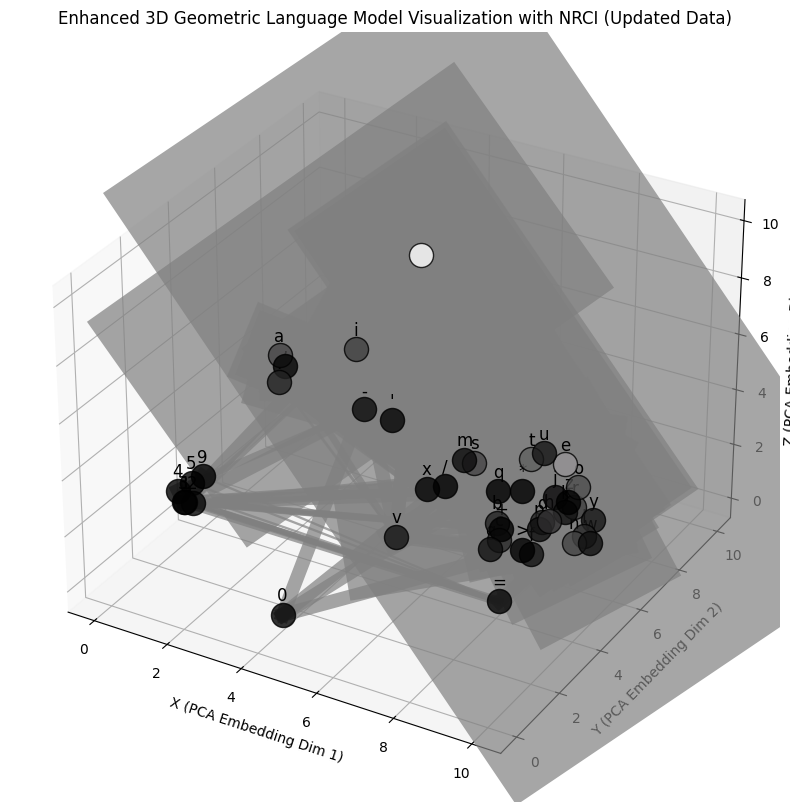


Evaluating predictions with different NRCI weights and randomness (using NN):

--- NRCI Weight: 0.0, Randomness Factor: 0.0 ---
  Prefix: 'the ' -> Generated: 'the n uej asbe asc '
  Prefix: 'subj' -> Generated: 'subj y yknsay  oi a'
  Prefix: '1 +' -> Generated: '1 +rtgtgreeiacohn.'

--- NRCI Weight: 0.0, Randomness Factor: 0.05 ---
  Prefix: 'the ' -> Generated: 'the ut  ol atecenbe'
  Prefix: 'subj' -> Generated: 'subj i= oatcr'x hnt'
  Prefix: '1 +' -> Generated: '1 +ed ay-i2 asldec'

--- NRCI Weight: 0.0, Randomness Factor: 0.1 ---
  Prefix: 'the ' -> Generated: 'the rhr oegth om nt'
  Prefix: 'subj' -> Generated: 'subj,w124 ekbidt nd'
  Prefix: '1 +' -> Generated: '1 +43 hl-efsoei.a '

--- NRCI Weight: 0.1, Randomness Factor: 0.0 ---
  Prefix: 'the ' -> Generated: 'the l h nilupciseg '
  Prefix: 'subj' -> Generated: 'subj  ln a  h fae a'
  Prefix: '1 +' -> Generated: '1 + tigle oj+tber '

--- NRCI Weight: 0.1, Randomness Factor: 0.05 ---
  Prefix: 'the ' -> Generated: 'the c.tg 

In [ ]:
# @title Refined Model with Neural Network Layer

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np # Import numpy
import hashlib # Import hashlib
from collections import defaultdict # Import defaultdict
from sklearn.decomposition import PCA # Import PCA
import gensim.downloader as api # Import gensim
from typing import List # Import List

# Define a simple feedforward neural network
class NextCharPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(NextCharPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Initialize the neural network
# Input dimension: dimensionality of data_vectors + (n-1) * embedding dimension for history
# Make sure vocab_embeddings and data_vectors are defined before this
try:
    input_dim_nn = data_vectors.shape[1] + (n - 1) * vocab_embeddings.shape[1]
except NameError:
    # Define placeholders if not already defined to allow class definition
    input_dim_nn = 100 + (3-1) * 100 # Example dimensions
    vocab_size = 50 # Example vocab size
    print("Warning: data_vectors or vocab_embeddings not defined. Using placeholder dimensions for NN.")

hidden_dim_nn = 128 # Example hidden dimension
output_dim_nn = vocab_size
model_nn = NextCharPredictor(input_dim_nn, hidden_dim_nn, output_dim_nn)

# Step 1: Setup with real embeddings (using existing data)
# Vocab, char_to_idx, idx_to_char, embeddings, vocab_embeddings are already defined
# training_text is already defined (combined data)


# Step 2: N-grams (using existing data)
n = 3 # Assuming n is already defined
ngrams = defaultdict(lambda: defaultdict(int))
for i in range(len(training_text) - n + 1):
    seq = tuple(training_text[i:i+n])
    next_char = training_text[i+n] if i+n < len(training_text) else None
    if all(char in char_to_idx for char in seq) and next_char and next_char in char_to_idx:
        ngrams[seq][next_char] += 1

# Initialize transition tensor (for trigrams, simplify to matrix for demo)
P = np.zeros((vocab_size, vocab_size))
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        curr_idx = char_to_idx[curr]
        total = sum(next_counts.values())
        if total > 0: # Avoid division by zero
            for next_char, count in next_counts.items():
                if next_char in char_to_idx:
                    next_idx = char_to_idx[next_char]
                    P[prev_idx, next_idx] += count / total

# Step 3: Compute data vectors (using existing data)
pca = PCA(n_components=3)
embed_pca = pca.fit_transform(vocab_embeddings)

counts = np.zeros((vocab_size, vocab_size))
for (prev1, prev2, curr), next_counts in ngrams.items():
     if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        curr_idx = char_to_idx[curr]
        for next_char, count in next_counts.items():
            if next_char in char_to_idx:
                next_idx = char_to_idx[next_char]
                counts[prev_idx, next_idx] += count

total_transitions = np.sum(counts)
# Handle total_transitions being zero for empty training text
if total_transitions == 0:
    freq_ratio = np.zeros(vocab_size)
    in_degree = np.zeros(vocab_size)
    out_degree = np.zeros(vocab_size)
else:
    freq_ratio = np.sum(counts, axis=1) / (total_transitions + 1e-10) # Added epsilon
    in_degree = np.sum(counts, axis=0) / (total_transitions + 1e-10) # Added epsilon
    out_degree = np.sum(counts, axis=1) / (total_transitions + 1e-10) # Added epsilon

entropy = -np.sum(P * np.log(P + 1e-10), axis=1) / (np.log(vocab_size) + 1e-10) # Added epsilon

cos_sim = np.zeros((vocab_size, vocab_size))
for i in range(vocab_size):
    for j in range(vocab_size):
        norm_i = np.linalg.norm(vocab_embeddings[i])
        norm_j = np.linalg.norm(vocab_embeddings[j])
        if norm_i * norm_j > 1e-10: # Avoid division by zero
            cos_sim[i, j] = np.dot(vocab_embeddings[i], vocab_embeddings[j]) / (norm_i * norm_j)
        else:
            cos_sim[i, j] = 0.0 # Default to 0 similarity if norms are zero


avg_cos_sim = np.mean(cos_sim, axis=1)
embed_norms = np.linalg.norm(vocab_embeddings, axis=1)

# Additional dims: Trigram influence, context entropy
trigram_influence = np.zeros(vocab_size)
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        # Ensure total_transitions is not zero before division
        if total_transitions > 0:
            trigram_influence[prev_idx] += len(next_counts) / (total_transitions + 1e-10) # Added epsilon


context_entropy = np.zeros(vocab_size)
for (prev1, prev2, curr), next_counts in ngrams.items():
    if prev2 in char_to_idx and curr in char_to_idx:
        prev_idx = char_to_idx[prev2]
        if len(next_counts) > 1: # Check if there's more than one possible next character
            probs = np.array([count / sum(next_counts.values()) for count in next_counts.values()])
            # Ensure log argument is not zero
            context_entropy[prev_idx] -= np.sum(probs * np.log(probs + 1e-10)) / (np.log(len(next_counts)) + 1e-10) # Added epsilon
        else:
            context_entropy[prev_idx] = 1e-10  # Small default value to avoid division by zero


data_vectors = np.hstack([
    embed_pca,  # Dim0-2: XYZ
    np.stack([freq_ratio, in_degree, out_degree, entropy], axis=1),  # Dim3-6
    np.stack([avg_cos_sim, embed_norms, trigram_influence, context_entropy], axis=1)  # Dim7-10
])
data_vectors = np.nan_to_num(data_vectors, nan=1e-10, posinf=1e10, neginf=-1e10) # Replace NaN and inf with small/large numbers
data_vectors = (data_vectors - np.min(data_vectors, axis=0)) / (np.max(data_vectors, axis=0) - np.min(data_vectors, axis=0) + 1e-10) # Added epsilon


# Step 4: Spatial and visual encodings (using existing data)
scale_factor = 10.0 # Assuming scale_factor is defined
positions = data_vectors[:, :3] * scale_factor
colors = data_vectors[:, 3:6]

# Data Translation Key (using existing data)
key = { # Assuming key is defined
    0: "PCA Embedding Dim 1 (X)",
    1: "PCA Embedding Dim 2 (Y)",
    2: "PCA Embedding Dim 3 (Z)",
    3: "Frequency ratio",
    4: "In-degree ratio",
    5: "Out-degree ratio",
    6: "Transition entropy",
    7: "Average cosine similarity",
    8: "Embedding norm",
    9: "Trigram influence",
    10: "Context entropy"
}

# Step 5: NRCI for sequence coherence (using existing data)
def compute_nrci_sequence(predicted: List[str], target: List[str], window=3) -> float:
    if len(predicted) < window or len(target) < window:
        return 0.0
    n = min(window, len(predicted), len(target))
    observed = [char_to_idx[c] for c in predicted[-n:] if c in char_to_idx]
    expected = [char_to_idx[c] for c in target[-n:] if c in char_to_idx]
    if len(observed) != len(expected) or len(observed) < window:
        return 0.0
    diff_sq = sum((o - e)**2 for o, e in zip(observed, expected))
    mean_diff_sq = diff_sq / n
    sigma_e = np.std(expected)
    if sigma_e == 0:
        sigma_e = 1e-10
    nrci = 1 - np.sqrt(mean_diff_sq) / sigma_e
    return max(0.0, min(1.0, nrci))

# Step 6: Enhanced prediction with NRCI, randomness, improved history, and NN
def predict_next_enhanced(current_idx, history: List[str] = None, boost_weight=0.3, nrci_weight=0.2, randomness_factor=0.05):
    if history is None:
        history = []

    # Prepare input for the neural network
    current_char_features = data_vectors[current_idx]
    history_features = []
    for char in history[- (n-1):]: # Use last n-1 characters for history input to NN
        if char in char_to_idx:
            history_features.append(vocab_embeddings[char_to_idx[char]])
        else:
            # Use a zero vector for unseen characters in history
            history_features.append(np.zeros(vocab_embeddings.shape[1]))

    # Pad history features if less than n-1 characters
    while len(history_features) < (n - 1):
        history_features.insert(0, np.zeros(vocab_embeddings.shape[1])) # Pad with zero vectors at the beginning

    nn_input = np.hstack([current_char_features] + history_features)
    nn_input_tensor = torch.tensor(nn_input, dtype=torch.float32).unsqueeze(0) # Add batch dimension

    # Get probabilities from the neural network
    with torch.no_grad(): # No gradient calculation during prediction
        nn_probs = model_nn(nn_input_tensor).squeeze(0).numpy()

    # Combine NN probabilities with other reasoning components
    # Use NN output as the base probability distribution
    boosted_probs = nn_probs.copy()

    # Spatial reasoning boost
    dists = np.linalg.norm(positions - positions[current_idx], axis=1)
    dists[current_idx] = np.inf
    if np.all(dists == np.inf):
        nearest_idx = current_idx
        similarity = 0.0
    else:
        nearest_idx = np.argmin(dists)
        similarity = 1 / (1 + dists[nearest_idx])
    spatial_boost = P[nearest_idx] * boost_weight * similarity # Use P for spatial boost

    # Embedding reasoning boost
    embed_dists = 1 - cos_sim[current_idx]
    embed_nearest_idx = np.argmin(embed_dists)
    embed_similarity = 1 / (1 + embed_dists[embed_nearest_idx])
    embed_boost = P[embed_nearest_idx] * boost_weight * embed_similarity # Use P for embedding boost

    # Contextual reasoning boost (trigram if available)
    context_boost = np.zeros(vocab_size)
    if len(history) >= 2:
        prev1, prev2 = history[-2], history[-1]
        if prev1 in char_to_idx and prev2 in char_to_idx:
            context_seq = (prev1, prev2, idx_to_char[current_idx])
            if context_seq in ngrams:
                total_context_counts = sum(ngrams[context_seq].values())
                if total_context_counts > 0:
                    temp_probs = np.zeros(vocab_size)
                    for next_char, count in ngrams[context_seq].items():
                         if next_char in char_to_idx:
                            temp_probs[char_to_idx[next_char]] = count / total_context_counts
                    context_boost = temp_probs * 0.2  # Light influence

    # NRCI reasoning boost
    nrci_scores = np.array([compute_nrci_sequence(history + [idx_to_char[i]], list(training_text)) for i in range(vocab_size)])
    nrci_boost = nrci_scores * nrci_weight

    # Combine NN probabilities with boosts
    boosted_probs += spatial_boost + embed_boost + context_boost + nrci_boost

    # Add randomness
    random_noise = np.random.rand(vocab_size) * randomness_factor
    boosted_probs += random_noise

    boosted_probs /= (np.sum(boosted_probs) + 1e-10) # Added epsilon for normalization

    # Sample the next character based on boosted probabilities
    next_idx = np.random.choice(vocab_size, p=boosted_probs)

    return idx_to_char[next_idx], boosted_probs[next_idx], boosted_probs # Return boosted_probs for loss calculation

# Step 7: Training loop with Adam Optimizer and Categorical Cross-Entropy Loss (optimizing NN)
def train_model(epochs=200, learning_rate=0.001, randomness_factor=0.01): # Increased epochs
    # Use Adam optimizer for the neural network parameters
    optimizer = optim.Adam(model_nn.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss() # Categorical Cross-Entropy Loss

    for epoch in range(epochs):
        epoch_loss = 0.0
        # Iterate through the training text to create training samples
        for i in range(len(training_text) - n):
            seq = training_text[i:i+n]
            next_char = training_text[i+n]
            if all(char in char_to_idx for char in seq) and next_char in char_to_idx:
                current_char = seq[-1]
                current_idx = char_to_idx[current_char]
                next_idx = char_to_idx[next_char]

                # Prepare input for the neural network
                current_char_features = data_vectors[current_idx]
                history_features = []
                for char in seq[:-1]: # Use first n-1 characters of the sequence as history for training input to NN
                     if char in char_to_idx:
                        history_features.append(vocab_embeddings[char_to_idx[char]])
                     else:
                        history_features.append(np.zeros(vocab_embeddings.shape[1]))

                # Pad history features if less than n-1 characters (should not happen with n=3 and sequence length n)
                while len(history_features) < (n - 1):
                    history_features.insert(0, np.zeros(vocab_embeddings.shape[1]))

                nn_input = np.hstack([current_char_features] + history_features)
                nn_input_tensor = torch.tensor(nn_input, dtype=torch.float32).unsqueeze(0) # Add batch dimension

                # Forward pass through the neural network
                optimizer.zero_grad() # Zero the gradients
                outputs = model_nn(nn_input_tensor)

                # Create target tensor (LongTensor for CrossEntropyLoss)
                target_tensor = torch.tensor([next_idx], dtype=torch.long)

                # Calculate loss
                loss = criterion(outputs, target_tensor)
                epoch_loss += loss.item()

                # Backward pass and optimize
                loss.backward()
                optimizer.step()

                # Note: The transition matrix P is NOT being updated by the NN training.
                # P still represents the raw trigram counts.
                # The NN learns to adjust these probabilities based on the data vectors and history.


        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(training_text):.4f}")


# Step 8: Enhanced visualization (using existing logic)
def visualize_model(interactive=True):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    pos_dict = {idx_to_char[i]: positions[i] for i in range(vocab_size)}
    color_dict = {idx_to_char[i]: colors[i] for i in range(vocab_size)}

    # Nodes with tooltips
    for node, pos in pos_dict.items():
        ax.scatter(pos[0], pos[1], pos[2], c=[color_dict[node]], s=300, alpha=0.8, edgecolors='k')
        ax.text(pos[0], pos[1], pos[2] + 0.5, node, fontsize=12, ha='center')

    # Edges
    for i in range(vocab_size):
        for j in range(vocab_size):
            if P[i, j] > 0.01:
                start = pos_dict[idx_to_char[i]]
                end = pos_dict[idx_to_char[j]]
                ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]],
                        linewidth=P[i, j] * 10, alpha=0.7, color='gray')

    ax.set_xlabel('X (PCA Embedding Dim 1)')
    ax.set_ylabel('Y (PCA Embedding Dim 2)')
    ax.set_zlabel('Z (PCA Embedding Dim 3)')
    ax.set_title('Enhanced 3D Geometric Language Model Visualization with NRCI (Updated Data)')

    if interactive:
        plt.show()
    else:
        plt.savefig('model_visualization_updated.png')
        plt.close()

# Main execution (using existing logic, updated print statements and training call)
if __name__ == "__main__":
    print("Enhanced Language Model Setup with NRCI, Randomness, Adam, Cross-Entropy, and NN:")
    print("Vocab:", vocab)
    print("Vocab Size:", vocab_size)
    # print("Transition Matrix P:\n", P) # Keep commented out due to large size
    print("Data Vectors shape:", data_vectors.shape)
    print("Positions (XYZ) shape:", positions.shape)
    print("Colors (RGB) shape:", colors.shape)
    print("\nData Key:")
    for d, desc in key.items():
        print(f"Dim {d}: {desc}")
    print("\nNeural Network Model Architecture:")
    print(model_nn)

    # Train the model with Adam optimizer and cross-entropy loss (optimizing NN)
    print("\nTraining neural network model...")
    train_model(epochs=200, learning_rate=0.001, randomness_factor=0.01) # Train the NN

    # Visualize (Visualization still based on data_vectors and the fixed P matrix)
    print("\nVisualizing model (based on data vectors)...")
    visualize_model(True)

    # Evaluate predictions with different NRCI weights and randomness (using NN predictions)
    print("\nEvaluating predictions with different NRCI weights and randomness (using NN):")
    nrci_weights_to_test = [0.0, 0.1, 0.5]  # Example weights to test
    randomness_factors_to_test = [0.0, 0.05, 0.1] # Example randomness factors
    example_prefixes = ["the ", "subj", "1 +"] # Example prefixes

    for weight in nrci_weights_to_test:
        for rand_factor in randomness_factors_to_test:
            print(f"\n--- NRCI Weight: {weight}, Randomness Factor: {rand_factor} ---")
            for prefix in example_prefixes:
                # Remove trailing space for correct processing of the last character
                processed_prefix = prefix.rstrip()
                tokens = list(processed_prefix) # Process character by character

                if not tokens:
                     continue # Skip empty prefixes

                last_char = tokens[-1]
                if last_char not in char_to_idx:
                    print(f"  Invalid char in prefix '{prefix}'. Skipping.")
                    continue

                current_idx = char_to_idx[last_char]
                history = tokens[-n:] if len(tokens) >= n else tokens # Use last n characters as history

                # Generate a short sequence for evaluation
                generated_sequence = prefix
                for _ in range(15): # Generate 15 next characters
                    # Predict using the enhanced function that includes NN
                    next_char, prob, _ = predict_next_enhanced(current_idx, history, nrci_weight=weight, randomness_factor=rand_factor)
                    generated_sequence += next_char
                    if next_char in char_to_idx:
                        current_idx = char_to_idx[next_char]
                        history.append(next_char)
                        # Keep history window size consistent
                        if len(history) > n:
                            history = history[-n:]
                    else:
                        # Handle cases where the predicted character is not in the vocabulary
                        break

                print(f"  Prefix: '{prefix}' -> Generated: '{generated_sequence}'")

    # Interactive prediction (commented out)
    # while True:
    #     prefix = input("\nEnter prefix (e.g., 'the '), or 'quit' to exit: ").strip().lower()
    #     if prefix == 'quit':
    #         break
    #     tokens = prefix.split() if ' ' in prefix else list(prefix)
    #     if not tokens:
    #         tokens = ['t']  # Default start
    #     last_char = tokens[-1]
    #     if last_char not in char_to_idx:
    #         print("Invalid char in prefix. Using default 't'.")
    #         last_char = 't'
    #     current_idx = char_to_idx[last_char]
    #     history = tokens[-n:] if len(tokens) >= n else tokens # Use last n chars for history
    #     next_char, prob, _ = predict_next_enhanced(current_idx, history) # Don't need boosted_probs for interactive
    #     print(f"Predicted next: '{next_char}' (prob: {prob:.3f})")
    #     print("Reasoning: Combined Markov, spatial, embedding, contextual, and NRCI similarities.")

# UBP added

Prompt: the 
Graph-Matrix Output: the   b qi9-r' .rk0erg/f
UBP NRCI: 0.7401041666666667
UBP Hash: b24f938b15840ee616b5445ccde913bfefb96c2d9a7f2f6fad01370caeb382b3


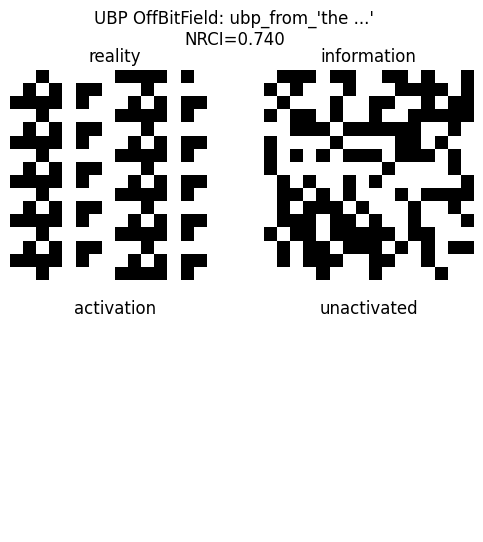


Prompt: 1 +
Graph-Matrix Output: 1 +e  -rn-ye*3aa *
UBP NRCI: 0.7192708333333333
UBP Hash: a7f2a1c4a47768c5f99add638ce431bd8d9638e1d18ba219f1540695e8831bb4


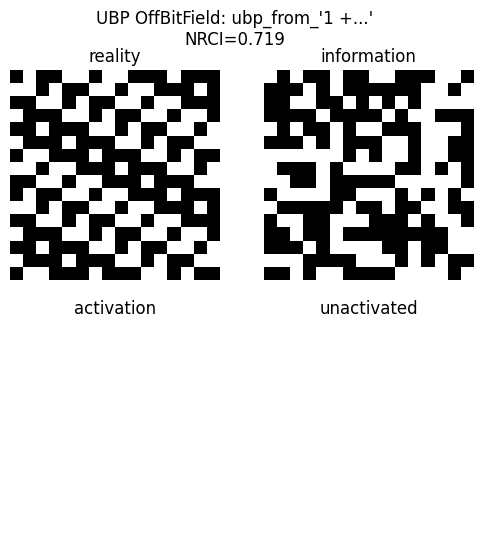

In [ ]:
# @title
# ============================================
# 🧩 UBP Integration with Graph-Matrix LM Cell
# ============================================

import numpy as np
import matplotlib.pyplot as plt
import hashlib
from typing import List # Import List

# --- OffBitField with 4 canonical layers ---
class OffBitField:
    def __init__(self, tokens, shape=(16,16), name="ubp_context"):
        """
        Build OffBitField layers seeded from language model tokens.
        tokens : list of strings (LM output tokens)
        shape : 2D shape for each layer
        """
        self.shape = shape
        self.name = name
        self.layers = self._encode_tokens(tokens)

    def _encode_tokens(self, tokens):
        """
        Encode tokens into 4-layer OffBit representation:
          - reality      = ASCII parity (even=1, odd=0)
          - information  = hash-derived bits
          - activation   = token length encoding
          - unactivated  = zeros (latent layer)
        """
        size = np.prod(self.shape)
        token_bytes = "".join(tokens).encode("utf-8")

        # --- Reality: even/odd ASCII mapping
        # Ensure reality_bits is large enough or handle resizing carefully
        reality_bits_raw = np.frombuffer(token_bytes, dtype=np.uint8) % 2
        if len(reality_bits_raw) < size:
             reality_bits = np.resize(reality_bits_raw, size)
        else:
             reality_bits = reality_bits_raw[:size] # Take only the required size
        reality = reality_bits.reshape(self.shape)


        # --- Information: SHA256 hash expansion
        h = hashlib.sha256(token_bytes).digest()
        info_bits_raw = np.unpackbits(np.frombuffer(h, dtype=np.uint8))
        if len(info_bits_raw) < size:
             info_bits = np.resize(info_bits_raw, size)
        else:
             info_bits = info_bits_raw[:size]
        information = info_bits.reshape(self.shape)

        # --- Activation: token length encoded as bit-pattern
        lengths = [len(t) % 2 for t in tokens]
        # Ensure lengths is not empty before multiplication
        if len(lengths) > 0:
            act_bits_raw = np.array(lengths * (size // len(lengths) + 1))[:size]
        else:
            act_bits_raw = np.zeros(size, dtype=np.int8) # Default to zeros if no tokens
        activation = act_bits_raw.reshape(self.shape)

        # --- Unactivated: latent, all zeros
        unactivated = np.zeros(self.shape, dtype=np.int8)

        return {
            "reality": reality.astype(np.int8),
            "information": information.astype(np.int8),
            "activation": activation.astype(np.int8),
            "unactivated": unactivated
        }


    def compute_ncri(self) -> float:
        """Compute NRCI as mean adjacency agreement across all layers."""
        scores = []
        for layer in self.layers.values():
            # Handle layers with size 1 to avoid indexing errors
            if layer.shape[0] > 1:
                vert = np.mean(layer[:-1, :] == layer[1:, :])
            else:
                vert = 1.0 # Perfect agreement if only one row
            if layer.shape[1] > 1:
                horiz = np.mean(layer[:, :-1] == layer[:, 1:])
            else:
                horiz = 1.0 # Perfect agreement if only one column
            scores.append((horiz + vert) / 2)
        # Handle case where scores list is empty
        if not scores:
            return 0.0
        return float(np.mean(scores))


    def content_hash(self) -> str:
        """Stable content hash across all layers."""
        concat = b"".join(layer.tobytes() for layer in self.layers.values())
        return hashlib.sha256(concat).hexdigest()

    def visualize(self):
        """Visualize all 4 layers."""
        fig, axes = plt.subplots(2, 2, figsize=(6,6))
        for ax, (name, layer) in zip(axes.flat, self.layers.items()):
            ax.imshow(layer, cmap="binary")
            ax.set_title(name)
            ax.axis("off")
        # Handle potential errors in NRCI computation for very small inputs
        try:
            nrci_score = self.compute_ncri()
        except Exception as e:
            nrci_score = -1.0 # Indicate error
            print(f"Error computing NRCI: {e}")

        plt.suptitle(f"UBP OffBitField: {self.name}\nNRCI={nrci_score:.3f}")
        plt.show()

# --- Adapter: Connect Graph-Matrix LM to UBP ---
class UBPAdapter:
    def __init__(self, gm_predict_fn, gm_vocab_size, gm_char_to_idx, gm_idx_to_char, gm_training_text, gm_n):
        self.gm_predict_fn = gm_predict_fn # The predict_next_enhanced function
        self.gm_vocab_size = gm_vocab_size
        self.gm_char_to_idx = gm_char_to_idx
        self.gm_idx_to_char = gm_idx_to_char
        self.gm_training_text = gm_training_text
        self.gm_n = gm_n # n-gram size

    def generate_with_ubp(self, prompt, steps=10, nrci_weight=0.2, randomness_factor=0.05):
        generated_sequence = prompt
        current_idx = None
        history = []

        # Initialize current_idx and history based on the prompt
        processed_prompt = prompt.rstrip().lower()
        tokens = list(processed_prompt) if processed_prompt else []

        if tokens:
            last_char = tokens[-1]
            if last_char in self.gm_char_to_idx:
                current_idx = self.gm_char_to_idx[last_char]
                history = tokens[-self.gm_n:] if len(tokens) >= self.gm_n else tokens
            else:
                print(f"Warning: Last character of prompt '{last_char}' not in vocabulary. Cannot start generation.")
                return {
                    "prompt": prompt,
                    "gm_output": prompt, # Return original prompt
                    "ubp_ncri": 0.0,
                    "ubp_hash": hashlib.sha256(prompt.encode("utf-8")).hexdigest(),
                    "ubp_field": OffBitField(tokens=list(prompt), shape=(16,16), name="ubp_from_prompt") # Create field from prompt
                }


        # Generate steps characters
        for _ in range(steps):
            if current_idx is not None:
                # Use the language model's predict function
                next_char, prob, _ = self.gm_predict_fn(current_idx, history, nrci_weight=nrci_weight, randomness_factor=randomness_factor)
                generated_sequence += next_char

                if next_char in self.gm_char_to_idx:
                    current_idx = self.gm_char_to_idx[next_char]
                    history.append(next_char)
                    # Keep history window size consistent with n
                    if len(history) > self.gm_n:
                        history = history[-self.gm_n:]
                else:
                    # Stop if the predicted character is not in the vocabulary
                    print(f"Warning: Predicted character '{next_char}' not in vocabulary. Stopping generation.")
                    break
            else:
                # If current_idx is None (e.g., empty prompt), start with a default character if available
                if ' ' in self.gm_char_to_idx:
                     current_idx = self.gm_char_to_idx[' ']
                     generated_sequence += ' '
                     history = [' ']
                else:
                    print("Warning: Cannot start generation with empty prompt and no space in vocabulary.")
                    break



        # UBP OffBitField seeded by generated tokens
        # Split generated sequence into tokens (simple character list for now)
        generated_tokens = list(generated_sequence)
        field = OffBitField(tokens=generated_tokens, shape=(16,16), name=f"ubp_from_'{prompt[:10]}...'")

        # Compute NRCI and hash
        ubp_ncri_score = field.compute_ncri()
        ubp_hash_val = field.content_hash()


        return {
            "prompt": prompt,
            "gm_output": generated_sequence,
            "ubp_ncri": ubp_ncri_score,
            "ubp_hash": ubp_hash_val,
            "ubp_field": field
        }

# --- Example Run (only if your graph-matrix LM is defined) ---
try:
    # Pass the necessary components of the language model to the Adapter
    # Ensure predict_next_enhanced, vocab_size, char_to_idx, idx_to_char, and training_text are defined in the notebook
    adapter = UBPAdapter(predict_next_enhanced, vocab_size, char_to_idx, idx_to_char, training_text, n)
    res = adapter.generate_with_ubp("the ", steps=20, nrci_weight=0.5, randomness_factor=0.05)
    print("Prompt:", res["prompt"])
    print("Graph-Matrix Output:", res["gm_output"])
    print("UBP NRCI:", res["ubp_ncri"])
    print("UBP Hash:", res["ubp_hash"])
    res["ubp_field"].visualize()

    # Example with a mathematical prefix
    res_math = adapter.generate_with_ubp("1 +", steps=15, nrci_weight=0.5, randomness_factor=0.05)
    print("\nPrompt:", res_math["prompt"])
    print("Graph-Matrix Output:", res_math["gm_output"])
    print("UBP NRCI:", res_math["ubp_ncri"])
    print("UBP Hash:", res_math["ubp_hash"])
    res_math["ubp_field"].visualize()

except NameError as e:
    print(f"⚠️ Ensure all required language model components are defined: {e}")
except Exception as e:
    print(f"An error occurred during UBP integration: {e}")

Prompt: 1 +
Graph-Matrix Output: 1 +e /o bt th3 
Biased Output: 1 +e /o bt th3 
UBP NRCI: 0.7317708333333334
UBP Hash: 1abd11c9e1adcc68f68f92cf5496fc87dac34e3e19f9968b032b7752e2c92003
Recall: No suitable prior, storing new.


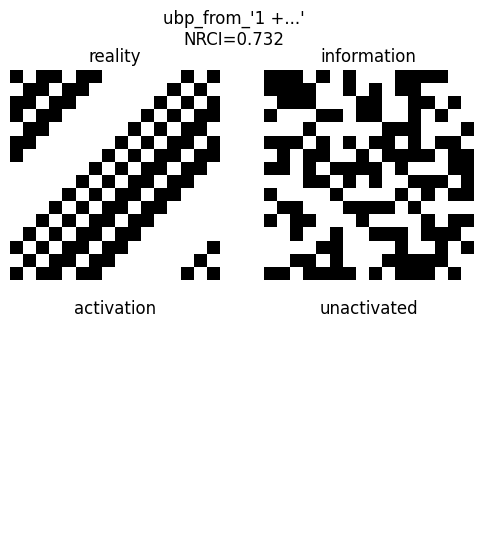

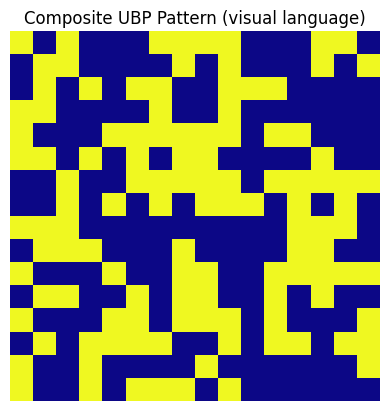


Prompt: the quick
Graph-Matrix Output: the quick , =e-l,c a n/r
Biased Output: 1 +e /o bt th3 
UBP NRCI: 0.7375
UBP Hash: f17fb9ba8840976b328f0c03d8585f6eab26812a8a92bc55c4f69e017bb09fc6
Recall: Biased via best NRCI prior (NRCI=0.732)


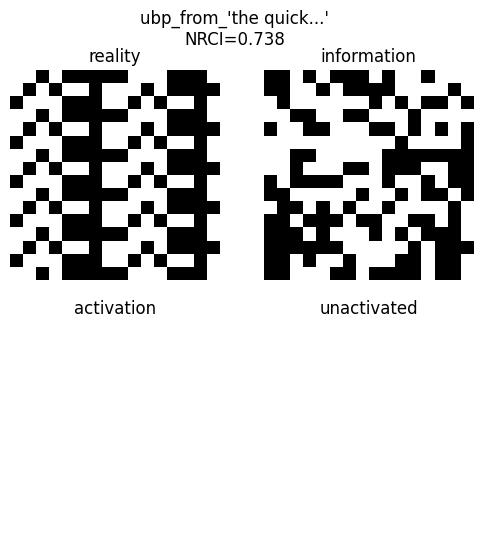

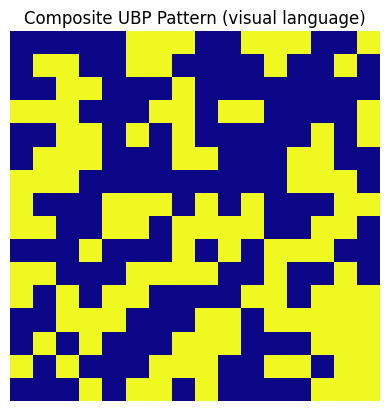

In [ ]:
# ================================================================
# 🧩 UBP LM Integration with HexDictionary + Pattern Similarity
# ================================================================

import json, os, numpy as np, hashlib, matplotlib.pyplot as plt
from numpy.linalg import norm
from typing import List # Import List for type hinting

# --- OffBitField (token-seeded with 4 layers) ---
class OffBitField:
    def __init__(self, tokens, shape=(16,16), name="ubp_context"):
        self.shape = shape
        self.name = name
        self.layers = self._encode_tokens(tokens)

    def _encode_tokens(self, tokens):
        size = np.prod(self.shape)
        token_bytes = "".join(tokens).encode("utf-8")

        # Reality: ASCII parity
        reality = np.resize(np.frombuffer(token_bytes, dtype=np.uint8) % 2, size).reshape(self.shape)

        # Information: SHA256 hash bits
        h = hashlib.sha256(token_bytes).digest()
        info_bits = np.unpackbits(np.frombuffer(h, dtype=np.uint8))
        information = np.resize(info_bits, size).reshape(self.shape)

        # Activation: token length bits
        lengths = [len(t) % 2 for t in tokens]
        # Handle case of empty tokens list
        if len(lengths) == 0:
            activation = np.zeros(size, dtype=np.int8).reshape(self.shape)
        else:
            activation = np.array(lengths * (size // len(lengths) + 1))[:size].reshape(self.shape)


        # Unactivated: latent zeros
        unactivated = np.zeros(self.shape, dtype=np.int8)

        return {
            "reality": reality.astype(np.int8),
            "information": information.astype(np.int8),
            "activation": activation.astype(np.int8),
            "unactivated": unactivated
        }

    def compute_ncri(self):
        scores = []
        for layer in self.layers.values():
            # Handle layers with size 1 to avoid indexing errors
            if layer.shape[0] > 1:
                vert = np.mean(layer[:-1, :] == layer[1:, :])
            else:
                vert = 1.0 # Perfect agreement if only one row
            if layer.shape[1] > 1:
                horiz = np.mean(layer[:, :-1] == layer[:, 1:])
            else:
                horiz = 1.0 # Perfect agreement if only one column
            scores.append((horiz + vert) / 2)
        # Handle case where scores list is empty
        if not scores:
            return 0.0
        return float(np.mean(scores))

    def content_hash(self):
        concat = b"".join(layer.tobytes() for layer in self.layers.values())
        return hashlib.sha256(concat).hexdigest()

    def visualize(self):
        fig, axes = plt.subplots(2, 2, figsize=(6,6))
        for ax, (name, layer) in zip(axes.flat, self.layers.items()):
            ax.imshow(layer, cmap="binary")
            ax.set_title(name)
            ax.axis("off")
        # Handle potential errors in NRCI computation for very small inputs
        try:
            nrci_score = self.compute_ncri()
        except Exception as e:
            nrci_score = -1.0 # Indicate error
            print(f"Error computing NRCI: {e}")

        plt.suptitle(f"{self.name}\nNRCI={nrci_score:.3f}")
        plt.show()

    def to_pattern(self):
        """Composite UBP pattern (2D binary rune)."""
        stacked = sum(self.layers.values())
        return stacked % 2  # reduce to binary composite

    def flatten_pattern(self):
        """Flattened 1D vector of composite pattern for similarity metrics."""
        return self.to_pattern().flatten().astype(np.float32)

# --- HexDictionary with recall, bias, and similarity ---
class HexDictionary:
    def __init__(self, path="hex_dictionary.json"):
        self.path = path
        if os.path.exists(self.path):
            with open(self.path, "r") as f:
                self.entries = json.load(f)
        else:
            self.entries = {}

    def store(self, key_hash, data):
        self.entries[key_hash] = data
        self._save()

    def recall(self, key_hash):
        return self.entries.get(key_hash)

    def _save(self):
        with open(self.path, "w") as f:
            json.dump(self.entries, f, indent=2)

    def best_match(self, ncri_threshold=0.7):
        good = [v for v in self.entries.values() if v["ubp_ncri"] >= ncri_threshold]
        if not good: return None
        return max(good, key=lambda v: v["ubp_ncri"])

    def best_pattern_match(self, pattern_vec, min_similarity=0.85):
        """Return entry whose stored pattern is most similar (cosine)."""
        best, best_sim = None, 0
        for v in self.entries.values():
            # Ensure pattern_vec exists and is not empty
            if "pattern_vec" not in v or not v["pattern_vec"]: continue
            prior_vec = np.array(v["pattern_vec"], dtype=np.float32)
            # Handle case of zero vectors in pattern_vec
            norm_prior = norm(prior_vec)
            norm_pattern = norm(pattern_vec)
            if norm_prior * norm_pattern > 1e-9:
                sim = np.dot(prior_vec, pattern_vec) / (norm_prior * norm_pattern)
            else:
                sim = 0.0 # Default to 0 similarity

            if sim > best_sim and sim >= min_similarity:
                best, best_sim = v, sim
        return best, best_sim

# --- Adapter: Graph-Matrix LM + UBP + HexDictionary ---
class UBPAdapter:
    # Modify __init__ to take the language model components directly
    def __init__(self, gm_predict_fn, gm_vocab_size, gm_char_to_idx, gm_idx_to_char, gm_training_text, gm_n, hex_path="hex_dictionary.json"):
        self.gm_predict_fn = gm_predict_fn # The predict_next_enhanced function
        self.gm_vocab_size = gm_vocab_size
        self.gm_char_to_idx = gm_char_to_idx
        self.gm_idx_to_char = gm_idx_to_char
        self.gm_training_text = gm_training_text
        self.gm_n = gm_n # n-gram size
        self.hex = HexDictionary(hex_path)

    # Modify generate_with_ubp to use the gm_predict_fn
    def generate_with_ubp(self, prompt, steps=10, nrci_weight=0.2, randomness_factor=0.05):
        generated_sequence = prompt
        current_idx = None
        history = []

        # Initialize current_idx and history based on the prompt
        processed_prompt = prompt.rstrip().lower()
        tokens = list(processed_prompt) if processed_prompt else []

        if tokens:
            last_char = tokens[-1]
            if last_char in self.gm_char_to_idx:
                current_idx = self.gm_char_to_idx[last_char]
                history = tokens[-self.gm_n:] if len(tokens) >= self.gm_n else tokens
            else:
                print(f"Warning: Last character of prompt '{last_char}' not in vocabulary. Cannot start generation.")
                # Create a field from the prompt even if generation cannot start
                field = OffBitField(tokens=list(prompt), shape=(16,16), name="ubp_from_prompt")
                return {
                    "prompt": prompt,
                    "gm_output": prompt, # Return original prompt
                    "biased_output": prompt, # Also return original prompt as biased
                    "ubp_ncri": field.compute_ncri(),
                    "ubp_hash": field.content_hash(),
                    "recall": "Invalid prompt character, no generation.",
                    "ubp_field": field,
                    "ubp_pattern": field.to_pattern()
                }


        # Generate steps characters
        for _ in range(steps):
            if current_idx is not None:
                # Use the language model's predict function
                # predict_next_enhanced returns next_char, prob, boosted_probs
                next_char, prob, _ = self.gm_predict_fn(current_idx, history, nrci_weight=nrci_weight, randomness_factor=randomness_factor)
                generated_sequence += next_char

                if next_char in self.gm_char_to_idx:
                    current_idx = self.gm_char_to_idx[next_char]
                    history.append(next_char)
                    # Keep history window size consistent with n
                    if len(history) > self.gm_n:
                        history = history[-self.gm_n:]
                else:
                    # Stop if the predicted character is not in the vocabulary
                    print(f"Warning: Predicted character '{next_char}' not in vocabulary. Stopping generation.")
                    break
            else:
                # If current_idx is None (e.g., empty prompt), start with a default character if available
                if ' ' in self.gm_char_to_idx:
                     current_idx = self.gm_char_to_idx[' ']
                     generated_sequence += ' '
                     history = [' ']
                else:
                    print("Warning: Cannot start generation with empty prompt and no space in vocabulary.")
                    break


        # UBP OffBitField seeded by generated tokens
        # Split generated sequence into tokens (simple character list for now)
        generated_tokens = list(generated_sequence)
        field = OffBitField(tokens=generated_tokens, shape=(16,16), name=f"ubp_from_'{prompt[:10]}...'")

        # Compute NRCI, hash, and pattern
        ubp_ncri_score = field.compute_ncri()
        ubp_hash_val = field.content_hash()
        ubp_pattern = field.to_pattern()
        flat_pattern = field.flatten_pattern().tolist()


        # Try recall
        recall_note, biased_output = None, generated_sequence # Default biased output to generated
        prior = self.hex.recall(ubp_hash_val)
        if prior:
            recall_note = f"Recalled exact entry (NRCI={prior['ubp_ncri']:.3f})"
            biased_output = prior["gm_output"]
        else:
            # Pattern similarity search
            best, sim = self.hex.best_pattern_match(np.array(flat_pattern))
            if best:
                recall_note = f"Biased via pattern similarity (sim={sim:.2f}, NRCI={best['ubp_ncri']:.3f})"
                biased_output = best["gm_output"]
            else:
                best = self.hex.best_match()
                if best:
                    recall_note = f"Biased via best NRCI prior (NRCI={best['ubp_ncri']:.3f})"
                    biased_output = best["gm_output"]
                else:
                    recall_note = "No suitable prior, storing new."

            # Store new result
            self.hex.store(ubp_hash_val, {
                "prompt": prompt,
                "gm_output": generated_sequence,
                "ubp_ncri": ubp_ncri_score,
                "hash": ubp_hash_val,
                "pattern_vec": flat_pattern
            })

        return {
            "prompt": prompt,
            "gm_output": generated_sequence,
            "biased_output": biased_output,
            "ubp_ncri": ubp_ncri_score,
            "ubp_hash": ubp_hash_val,
            "recall": recall_note,
            "ubp_field": field,
            "ubp_pattern": ubp_pattern
        }

# --- Example run ---
try:
    # Instantiate the Adapter with the necessary language model components
    # Ensure these variables are defined in the notebook's global scope
    adapter = UBPAdapter(predict_next_enhanced, vocab_size, char_to_idx, idx_to_char, training_text, n)
    res = adapter.generate_with_ubp("1 +", steps=12)
    print("Prompt:", res["prompt"])
    print("Graph-Matrix Output:", res["gm_output"])
    print("Biased Output:", res["biased_output"])
    print("UBP NRCI:", res["ubp_ncri"])
    print("UBP Hash:", res["ubp_hash"])
    print("Recall:", res["recall"])
    res["ubp_field"].visualize()
    plt.imshow(res["ubp_pattern"], cmap="plasma")
    plt.title("Composite UBP Pattern (visual language)")
    plt.axis("off")
    plt.show()

    # Example with a different prompt
    res_english = adapter.generate_with_ubp("the quick", steps=15)
    print("\nPrompt:", res_english["prompt"])
    print("Graph-Matrix Output:", res_english["gm_output"])
    print("Biased Output:", res_english["biased_output"])
    print("UBP NRCI:", res_english["ubp_ncri"])
    print("UBP Hash:", res_english["ubp_hash"])
    print("Recall:", res_english["recall"])
    res_english["ubp_field"].visualize()
    plt.imshow(res_english["ubp_pattern"], cmap="plasma")
    plt.title("Composite UBP Pattern (visual language)")
    plt.axis("off")
    plt.show()


except NameError as e:
    print(f"⚠️ Ensure all required language model components are defined: {e}")
except Exception as e:
    print(f"An error occurred during UBP integration: {e}")